In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# from scipy.stats import binned_statistic_2d
# from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.cm as cm

# from abacusnbody.analysis.tsc import tsc_parallel
import time

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# Import packages

sys.path.append('../src/')
# from filter_utils import *
# from SZstacker import SZMapStacker # type: ignore
from utils import ksz_from_delta_sigma, arcmin_to_comoving, comoving_to_arcmin

from stacker import SimulationStacker

import illustris_python as il

import yaml
import argparse
from pathlib import Path
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# Create colormap for number density
colourmap = cm.twilight

# ===== Publication-Ready Figure Settings =====
# Set publication-quality defaults for all matplotlib figures
# Figure size parameters for consistent sizing across all plots
FIG_WIDTH_SINGLE = 8  # Width for single panel plots
FIG_WIDTH_DOUBLE = 18  # Width for 2-column plots
FIG_WIDTH_GRID = 16    # Width for grid layouts
FIG_DPI = 150          # Display DPI
FIG_SAVE_DPI = 200     # Saved figure DPI

FIG_SAVE_DIR = '/pscratch/sd/l/lindajin/DH_profile_kSZ_WL/figs/main/'

plt.rcParams.update({
    # Figure size and DPI
    'figure.dpi': FIG_DPI,
    'savefig.dpi': FIG_SAVE_DPI,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'figure.figsize': (FIG_WIDTH_SINGLE, 6),  # Default single panel size
    
    # Font sizes (minimum 12pt for paper)
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    
    # Font family
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif',
    
    # Line widths
    'axes.linewidth': 1.5,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.0,
    'lines.markersize': 6,
    'patch.linewidth': 1.0,
    
    # Tick settings
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.0,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.0,
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    
    # Legend
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.fancybox': False,
    'legend.edgecolor': 'black',
    
    # Grid
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    
    # Errorbar settings
    'errorbar.capsize': 3,
    
    # Scatter plot settings
    'scatter.marker': 'o',
    
    # Figure layout
    'figure.autolayout': False,
    'figure.constrained_layout.use': False,
    
    # Colors
    'axes.prop_cycle': plt.cycler('color', colourmap(np.linspace(0.1, 0.95, 6))),

    # PDF output
    'pdf.fonttype': 42,  # TrueType fonts (editable in Illustrator)
    'ps.fonttype': 42,
})




In [7]:
# Configuration parameters
sim_type = 'IllustrisTNG'
snapshot = 74
sim_name = 'L50n512_SB35'

load_field = False
save_field = False
rad_distance = 1.0  # in arcmin
mask_haloes = False
mask_radii = 3.0  # Number of virial radii to mask out for haloes. In units of R200c

min_radius = 1/6
max_radius = 6.0
num_radii = 15

projection = 'xy'  # 'xy', 'xz', 'yz'

### Profile parameters
pixel_size = 0.5  # in arcmin
filter_type = 'CAP'  # Options: 'CAP', 'cumulative', 'DSigma'
particle_type = 'tau'

n_pixels = 1000
filter_type_2 = 'DSigma'  # Options: 'CAP', 'cumulative', 'DSigma'
particle_type_2 = 'total'

### Physical parameters
number_densities = [1.0e-4, 2.8e-4, 5e-4, 1.0e-3, 2.4e-3]


# Profiles

In [8]:
base_path_template = '/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{}/data/'

ksz_profiles_xy_all_sims = []
delta_sigma_xy_profiles_all_sims = []
ksz_profiles_xz_all_sims = []
delta_sigma_xz_profiles_all_sims = []
ksz_profiles_yz_all_sims = []
delta_sigma_yz_profiles_all_sims = []
delta_sigma_arcmin_xy_profiles_all_sims = []
delta_sigma_arcmin_xz_profiles_all_sims = []
delta_sigma_arcmin_yz_profiles_all_sims = []
fb_all_sims = []

dsigma_halo_mass_bin_idx_all_sims = []
ksz_halo_mass_bin_idx_all_sims = []
dsigma_halo_bigwoods_mass_bin_idx_all_sims = []
ksz_halo_bigwoods_mass_bin_idx_all_sims = []

r0_arcmin_all_sims = []
r1_mpch_all_sims = []
r1_arcmin_all_sims =[]

dsigma_mass_bins = [13.00, 13.42, 13.83, 14.25]
ksz_mass_bins = [11, 11.25, 11.5, 12, 13.5]
bigwoods_ksz_mass_bin = [12, 12.5, 13, 13.5, 14]

for sim_id in np.arange(1024):
    profile_file = base_path_template.format(sim_id) + 'Profiles_tau-CAP_total-DSigma.npz'
    profiles_loaded = np.load(profile_file)
    ksz_profiles_xy_all_sims.append(profiles_loaded['prof0_tau_CAP_xy'])
    delta_sigma_xy_profiles_all_sims.append(profiles_loaded['prof1_total_DSigma_kpch2_xy'])
    delta_sigma_arcmin_xy_profiles_all_sims.append(profiles_loaded['prof1_total_DSigma_arcmin2_xy'])
    ksz_profiles_xz_all_sims.append(profiles_loaded['prof0_tau_CAP_xz'])
    delta_sigma_xz_profiles_all_sims.append(profiles_loaded['prof1_total_DSigma_kpch2_xz'])
    delta_sigma_arcmin_xz_profiles_all_sims.append(profiles_loaded['prof1_total_DSigma_arcmin2_xz'])
    ksz_profiles_yz_all_sims.append(profiles_loaded['prof0_tau_CAP_yz'])
    delta_sigma_yz_profiles_all_sims.append(profiles_loaded['prof1_total_DSigma_kpch2_yz'])
    delta_sigma_arcmin_yz_profiles_all_sims.append(profiles_loaded['prof1_total_DSigma_arcmin2_yz'])

    r0_arcmin = profiles_loaded['r0_arcmin']
    r1_mpch = profiles_loaded['r1_mpch']
    r0_arcmin_all_sims.append(r0_arcmin)
    r1_mpch_all_sims.append(r1_mpch)
    r1_arcmin_all_sims.append(profiles_loaded['r1_to_arcmin'])
    fb_all_sims.append(profiles_loaded['fb'])

    
    # Get halo masses and compute log10(M_sun/h)
    halo_masses = profiles_loaded['halo_masses']
    log_halo_masses = np.log10(halo_masses)

    bin_indices = np.digitize(log_halo_masses, dsigma_mass_bins)
    dsigma_halo_mass_bin_idx_all_sims.append(bin_indices)

    bin_indices_ksz = np.digitize(log_halo_masses, ksz_mass_bins)
    ksz_halo_mass_bin_idx_all_sims.append(bin_indices_ksz)

    bin_indices_bigwoods_ksz = np.digitize(log_halo_masses, bigwoods_ksz_mass_bin)
    ksz_halo_bigwoods_mass_bin_idx_all_sims.append(bin_indices_bigwoods_ksz)


print(f"\nLoaded profiles for projection (xy) from {len(ksz_profiles_xy_all_sims)} simulations")



Loaded profiles for projection (xy) from 1024 simulations


In [5]:
for key in profiles_loaded.keys():
    print(f"  {key}")

  prof0_tau_CAP_xy
  prof1_total_DSigma_arcmin2_xy
  prof1_total_DSigma_kpch2_xy
  prof0_tau_CAP_xz
  prof1_total_DSigma_arcmin2_xz
  prof1_total_DSigma_kpch2_xz
  prof0_tau_CAP_yz
  prof1_total_DSigma_arcmin2_yz
  prof1_total_DSigma_kpch2_yz
  r0_arcmin
  r0_to_mpch
  r1_mpch
  r1_to_arcmin
  halo_masses
  number_density
  nPixels01
  pixelSize01
  methods01
  units01
  fb
  HubbleParam


In [6]:
profiles_loaded['number_density'], len(profiles_loaded['halo_masses']), profiles_loaded['halo_masses'].min(), profiles_loaded['halo_masses'].max()

(array(0.0024), 300, np.float32(1135777700000.0), np.float32(52802592000000.0))

In [14]:
profiles_loaded['pixelSize01'],profiles_loaded['units01'],profiles_loaded['nPixels01']

(array([ 0.5, 50. ]),
 array(['arcmin', 'kpc/h'], dtype='<U6'),
 array([ 273, 1000]))

Converted HSC data units:
  r_mpc: [Mpc] -> [Mpc/h] (multiplied by h=0.7)
  dsigma_lr & dsigma_err_jk: [M_sun/pc^2] -> [M_sun*h/pc^2] (multiplied by h=0.7)


Subplot 1 - Bin 1: 70038 halos across all sims and projections
Subplot 2 - Bin 2: 21783 halos across all sims and projections
Subplot 2 - Bin 2: 21783 halos across all sims and projections
Subplot 3 - Bin 3: 5307 halos across all sims and projections
Subplot 3 - Bin 3: 5307 halos across all sims and projections


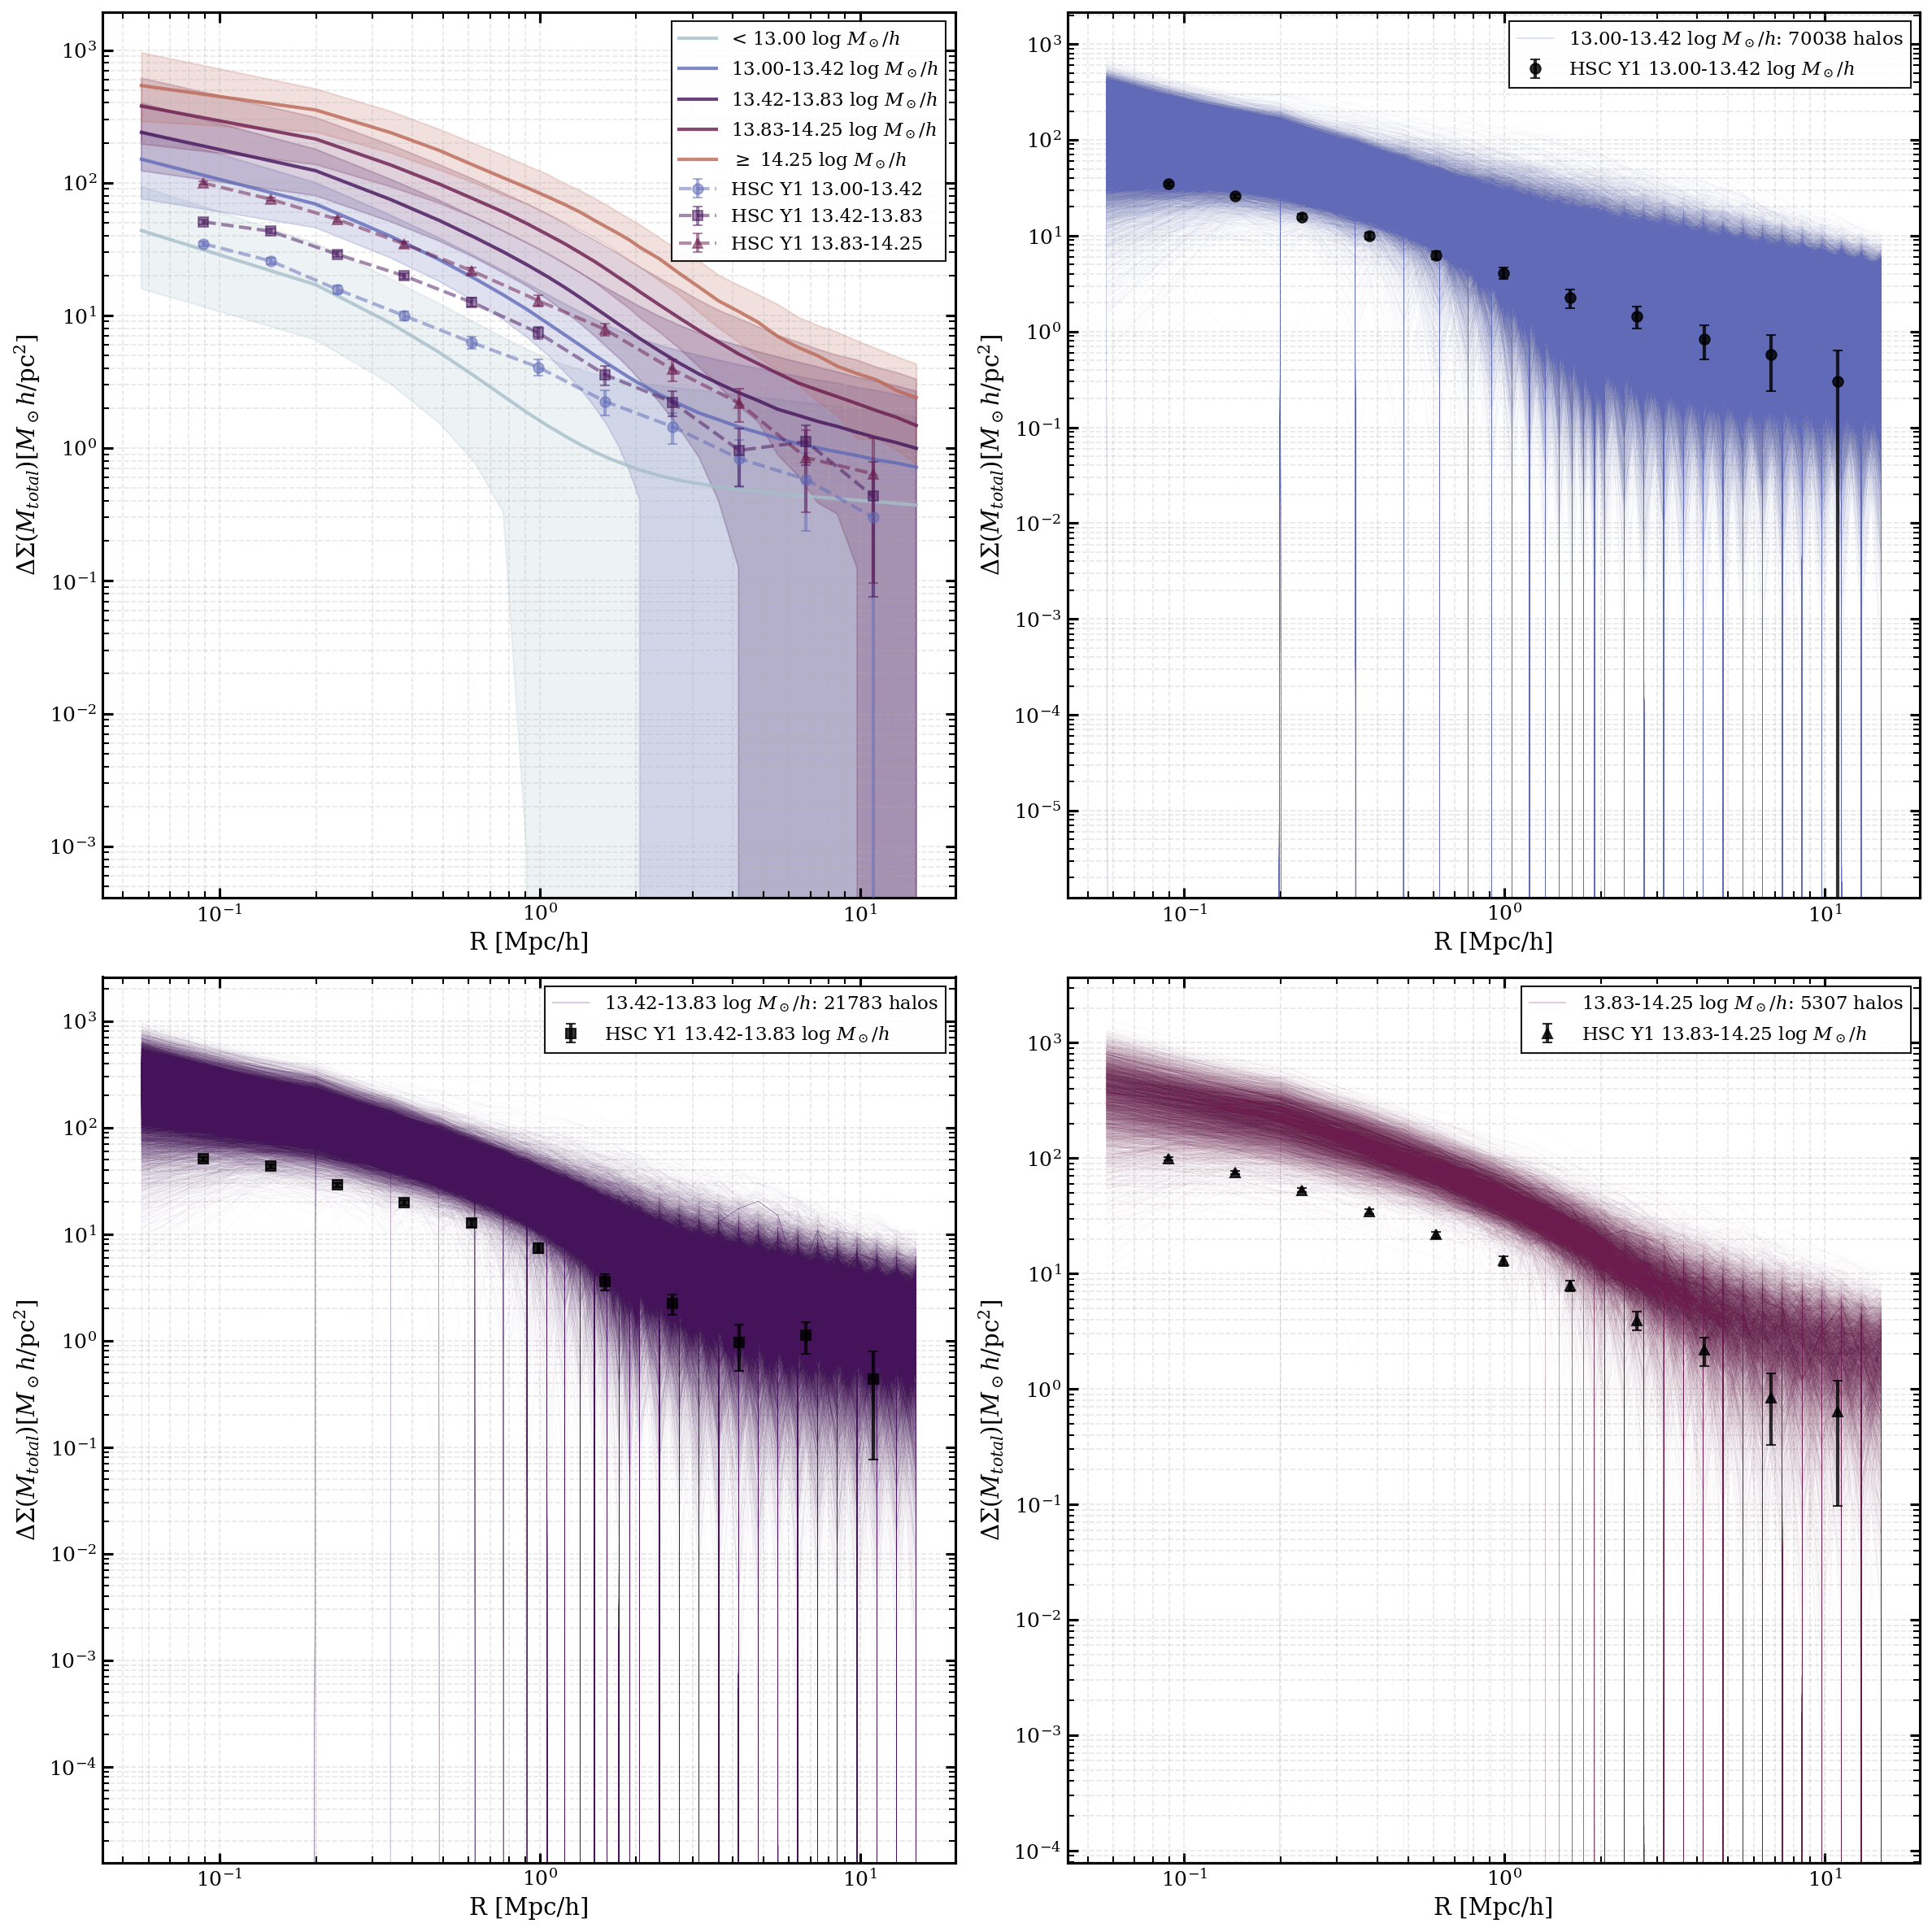

In [68]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D

HSC_data_mass_bin1 = np.load('hsc_s16a_dsigma_logmvir_13.00_13.42.npy')
HSC_data_mass_bin2 = np.load('hsc_s16a_dsigma_logmvir_13.42_13.83.npy')
HSC_data_mass_bin3 = np.load('hsc_s16a_dsigma_logmvir_13.83_14.25.npy')
# Convert HSC data units from H0=70 to h=0.7 convention
# H0 = 70 km/s/Mpc means h = 0.7
h = 0.7

# Convert r_mpc: [Mpc] -> [Mpc/h] (multiply by h)
HSC_data_mass_bin1['r_mpc'] *= h
HSC_data_mass_bin2['r_mpc'] *= h
HSC_data_mass_bin3['r_mpc'] *= h

# Convert dsigma and errors: [M_sun/pc^2] -> [M_sun*h/pc^2] (multiply by h)
HSC_data_mass_bin1['dsigma_lr'] *= h
HSC_data_mass_bin1['dsigma_err_jk'] *= h
HSC_data_mass_bin2['dsigma_lr'] *= h
HSC_data_mass_bin2['dsigma_err_jk'] *= h
HSC_data_mass_bin3['dsigma_lr'] *= h
HSC_data_mass_bin3['dsigma_err_jk'] *= h

print(f"Converted HSC data units:")
print(f"  r_mpc: [Mpc] -> [Mpc/h] (multiplied by h={h})")
print(f"  dsigma_lr & dsigma_err_jk: [M_sun/pc^2] -> [M_sun*h/pc^2] (multiplied by h={h})")

# Get radial bins
radii = r1_mpch  # in Mpc/h

# Extract colors from prop_cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
cycle_colors = prop_cycle.by_key()['color']

# Mass bin labels - 5 bins total
mass_bin_labels = [
    r'< 13.00 log $M_\odot/h$',
    r'13.00-13.42 log $M_\odot/h$',
    r'13.42-13.83 log $M_\odot/h$',
    r'13.83-14.25 log $M_\odot/h$',
    r'$\geq$ 14.25 log $M_\odot/h$'
]
mass_bin_colors = [cycle_colors[i] for i in range(5)]

hsc_data_list = [HSC_data_mass_bin1, HSC_data_mass_bin2, HSC_data_mass_bin3]
# hsc_colors = ['blue', 'green', 'orange']
hsc_colors = [cycle_colors[1], cycle_colors[2], cycle_colors[3]]
hsc_markers = ['o', 's', '^']

fig, axes = plt.subplots(2, 2, figsize=(FIG_WIDTH_GRID, FIG_WIDTH_GRID), dpi = FIG_DPI)
axes = axes.flatten()

# === SUBPLOT 0: All projections (xy, xz, yz) with all mass bins (mean across all sims) ===
ax = axes[0]
profiles_all_sims_xy = delta_sigma_xy_profiles_all_sims
profiles_all_sims_xz = delta_sigma_xz_profiles_all_sims
profiles_all_sims_yz = delta_sigma_yz_profiles_all_sims

for mass_bin_idx in range(5):
    all_profiles_this_bin = []
    
    for sim_id in range(len(profiles_all_sims_xy)):
        bin_indices = dsigma_halo_mass_bin_idx_all_sims[sim_id]
        mask = (bin_indices == mass_bin_idx)
        
        if np.sum(mask) > 0:
            # Collect profiles from all three projections
            profiles_xy = profiles_all_sims_xy[sim_id][:, mask]
            profiles_xz = profiles_all_sims_xz[sim_id][:, mask]
            profiles_yz = profiles_all_sims_yz[sim_id][:, mask]
            
            # Concatenate along the halo dimension
            profiles_this_bin = np.concatenate([profiles_xy, profiles_xz, profiles_yz], axis=1)
            all_profiles_this_bin.append(profiles_this_bin)
    
    if len(all_profiles_this_bin) > 0:
        all_profiles_concatenated = np.concatenate(all_profiles_this_bin, axis=1)
        all_profiles_concatenated *= 1e-6  # Convert from kpc^-2 to pc^-2
        
        median_profile = np.nanmedian(all_profiles_concatenated, axis=1)
        p16_profile = np.nanpercentile(all_profiles_concatenated, 16, axis=1)
        p84_profile = np.nanpercentile(all_profiles_concatenated, 84, axis=1)
        
        color = mass_bin_colors[mass_bin_idx]
        ax.plot(radii[:len(median_profile)], median_profile, color=color, 
               label=mass_bin_labels[mass_bin_idx], alpha=0.8)
        ax.fill_between(radii[:len(median_profile)], 
                       p16_profile, 
                       p84_profile, 
                       color=color, alpha=0.2)
        
        # print(f"All projections - Bin {mass_bin_idx}: {all_profiles_concatenated.shape[1]} halos (xy+xz+yz)")

# Add HSC data
ax.errorbar(HSC_data_mass_bin1['r_mpc'], HSC_data_mass_bin1['dsigma_lr'], 
           yerr=np.sqrt(HSC_data_mass_bin1['dsigma_err_jk']), 
           fmt=hsc_markers[0], color=hsc_colors[0], alpha=0.5, linestyle='--',
           label=r'HSC Y1 13.00-13.42', zorder=4)
ax.errorbar(HSC_data_mass_bin2['r_mpc'], HSC_data_mass_bin2['dsigma_lr'], 
           yerr=np.sqrt(HSC_data_mass_bin2['dsigma_err_jk']), 
           fmt=hsc_markers[1], color=hsc_colors[1], alpha=0.5, linestyle='--',
           label=r'HSC Y1 13.42-13.83', zorder=4)
ax.errorbar(HSC_data_mass_bin3['r_mpc'], HSC_data_mass_bin3['dsigma_lr'], 
           yerr=np.sqrt(HSC_data_mass_bin3['dsigma_err_jk']), 
           fmt=hsc_markers[2], color=hsc_colors[2], alpha=0.5, linestyle='--',
           label=r'HSC Y1 13.83-14.25', zorder=4)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [Mpc/h]')
ax.set_ylabel(r'$\Delta \Sigma (M_{total}) [M_\odot h / \mathrm{pc}^2]$')
ax.legend(loc='upper right', ncol=1)
ax.grid(True, which='both')

# === SUBPLOTS 1-3: Individual halo profiles from all simulations and projections for mass bins 1, 2, 3 ===

for subplot_idx, mass_bin_idx in enumerate([1, 2, 3]):
    ax = axes[subplot_idx + 1]
    
    # Collect all halo profiles from all simulations and all projections for this mass bin
    all_profiles_this_bin = []
    
    for sim_id in range(len(delta_sigma_xy_profiles_all_sims)):
        bin_indices = dsigma_halo_mass_bin_idx_all_sims[sim_id]
        mask = (bin_indices == mass_bin_idx)
        
        if np.sum(mask) > 0:
            # Collect profiles from all three projections
            profiles_xy = delta_sigma_xy_profiles_all_sims[sim_id][:, mask]
            profiles_xz = delta_sigma_xz_profiles_all_sims[sim_id][:, mask]
            profiles_yz = delta_sigma_yz_profiles_all_sims[sim_id][:, mask]
            
            # Concatenate along the halo dimension
            profiles_this_bin = np.concatenate([profiles_xy, profiles_xz, profiles_yz], axis=1)
            all_profiles_this_bin.append(profiles_this_bin)
    
    if len(all_profiles_this_bin) > 0:
        # Concatenate all profiles across all simulations
        all_profiles_concatenated = np.concatenate(all_profiles_this_bin, axis=1)
        all_profiles_concatenated *= 1e-6  # Convert to pc^-2
        
        # Plot each individual halo profile
        for halo_idx in range(all_profiles_concatenated.shape[1]):
            if halo_idx == 0:
                ax.plot(radii[:all_profiles_concatenated.shape[0]], 
                   all_profiles_concatenated[:, halo_idx], 
                   linewidth=0.2, alpha=1, color=mass_bin_colors[mass_bin_idx], label=f'{mass_bin_labels[mass_bin_idx]}: {all_profiles_concatenated.shape[1]} halos')
            else:
                ax.plot(radii[:all_profiles_concatenated.shape[0]], 
                   all_profiles_concatenated[:, halo_idx], 
                   linewidth=0.1, alpha=0.1, color=mass_bin_colors[mass_bin_idx])
            
        # # Calculate and plot median with 68% interval
        # median_profile = np.nanmedian(all_profiles_concatenated, axis=1)
        # p16_profile = np.nanpercentile(all_profiles_concatenated, 16, axis=1)
        # p84_profile = np.nanpercentile(all_profiles_concatenated, 84, axis=1)
        
        # ax.plot(radii[:len(median_profile)], median_profile, linewidth=3, 
        #        color=mass_bin_colors[mass_bin_idx], alpha=1.0, 
        #        label=f'Median', zorder=5)
        # ax.fill_between(radii[:len(median_profile)], 
        #                p16_profile, 
        #                p84_profile, 
        #                color=mass_bin_colors[mass_bin_idx], alpha=0.3, zorder=5)
        
        print(f"Subplot {subplot_idx+1} - Bin {mass_bin_idx}: {all_profiles_concatenated.shape[1]} halos across all sims and projections")
    
    # Add HSC data for this mass bin
    hsc_data = hsc_data_list[subplot_idx]
    ax.errorbar(hsc_data['r_mpc'], hsc_data['dsigma_lr'], 
               yerr=np.sqrt(hsc_data['dsigma_err_jk']), 
               fmt=hsc_markers[subplot_idx], 
               color='k', alpha=0.8,
               label=f'HSC Y1 {mass_bin_labels[mass_bin_idx]}', zorder=10)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('R [Mpc/h]')
    ax.set_ylabel(r'$\Delta \Sigma (M_{total}) [M_\odot h / \mathrm{pc}^2]$')
    ax.legend(loc='upper right')
    ax.grid(True, which='both')
    # ax.set_title(f'{all_profiles_concatenated.shape[1]} Halos - {mass_bin_labels[mass_bin_idx]}')


fig.tight_layout()
plt.show()
fig.savefig(FIG_SAVE_DIR + 'DeltaSigma_profiles_vs_HSC_Y1.pdf', bbox_inches='tight', dpi=FIG_SAVE_DPI)

KeysView(NpzFile 'Fig1_Fig8_dr10_allfoot_perbin_sigmaz0.0500_dr6_corr_pzbin1.npz' with keys: theta_arcmins, prof, cov)
All projections - kSZ Bin 1: 1380 halos (xy+xz+yz)
All projections - kSZ Bin 2: 12054 halos (xy+xz+yz)


All projections - kSZ Bin 3: 148851 halos (xy+xz+yz)
All projections - kSZ Bin 4: 738225 halos (xy+xz+yz)
All projections - kSZ Bin 5: 21090 halos (xy+xz+yz)
All projections - kSZ Bin 4: 738225 halos (xy+xz+yz)
All projections - kSZ Bin 5: 21090 halos (xy+xz+yz)


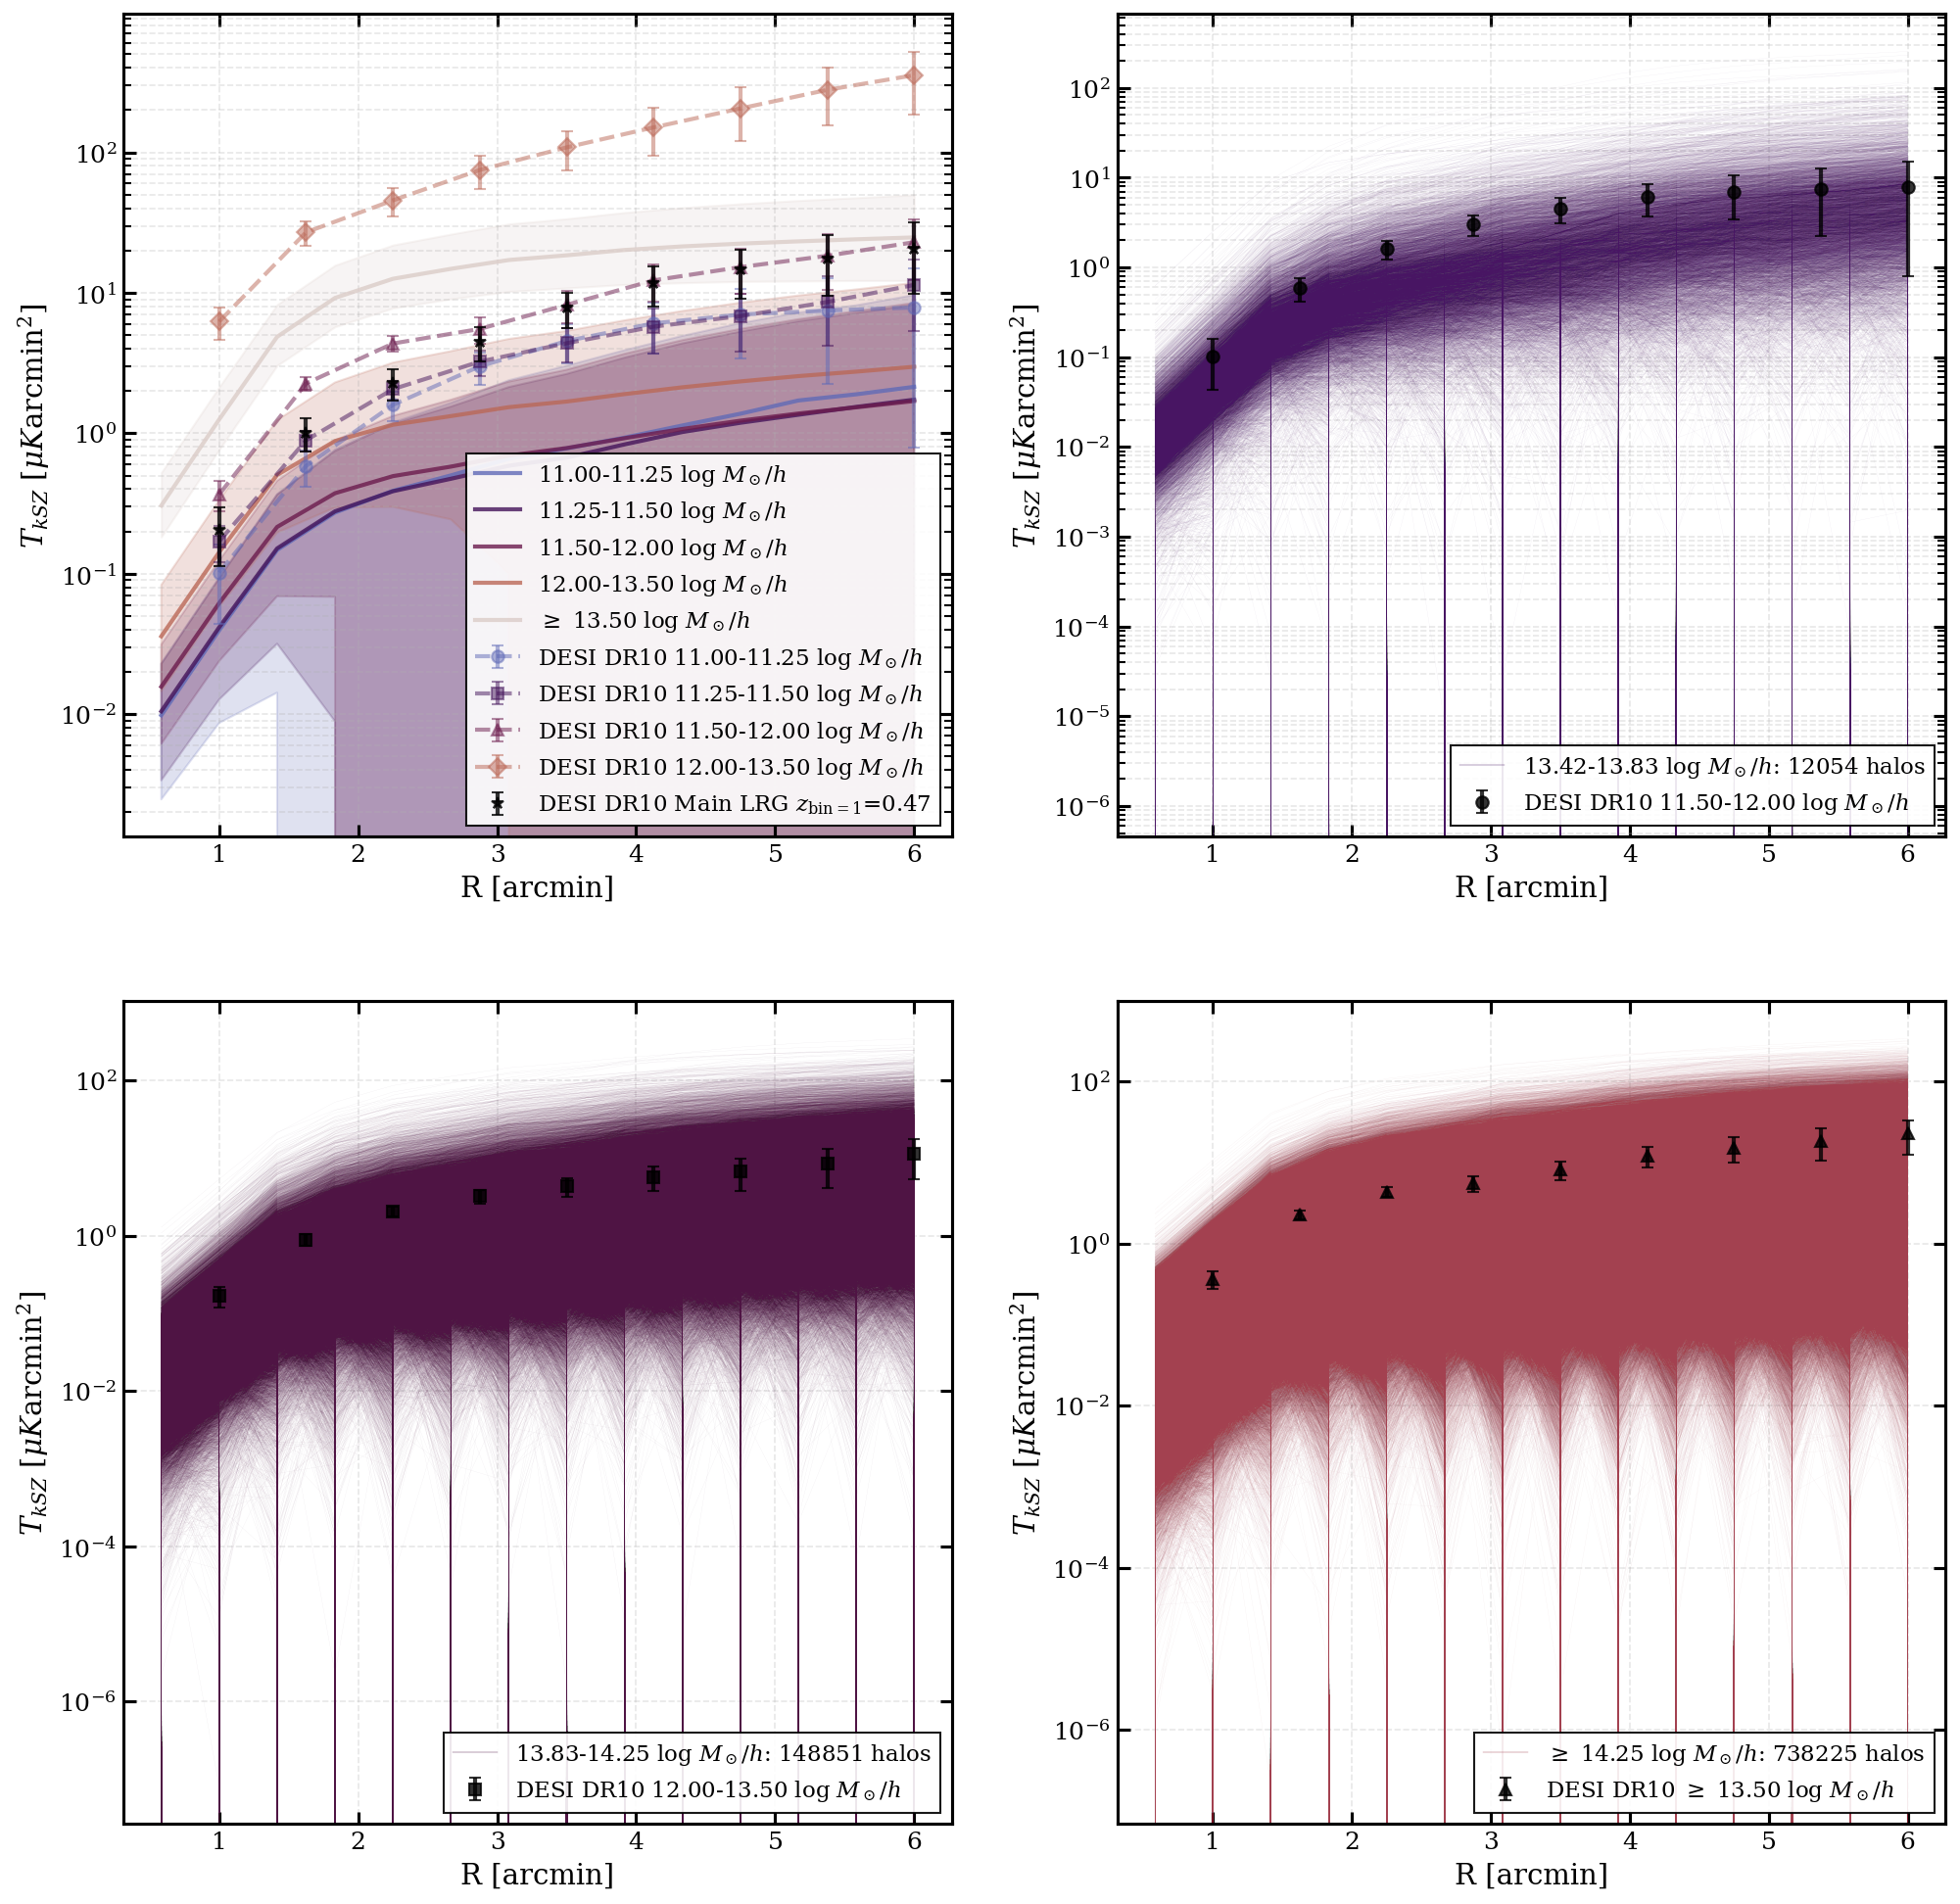

In [ ]:
DESI_data = np.load('Fig1_Fig8_dr10_allfoot_perbin_sigmaz0.0500_dr6_corr_pzbin1.npz')
print(DESI_data.keys())

# Load DESI data for different mass bins
DESI_mass_bin1 = np.load('Fig4_mass_11.00_11.25.npz')
DESI_mass_bin2 = np.load('Fig4_mass_11.25_11.50.npz')
DESI_mass_bin3 = np.load('Fig4_mass_11.50_12.00.npz')
DESI_mass_bin4 = np.load('Fig4_mass_12.00_13.50.npz')

# Get radial bins
radii = r0_arcmin  # in arcmin

# Extract colors from prop_cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
cycle_colors = prop_cycle.by_key()['color']

# Mass bin labels for kSZ - now 6 bins total
ksz_mass_bin_labels = [
    r'< 11.00 log $M_\odot/h$',
    r'11.00-11.25 log $M_\odot/h$',
    r'11.25-11.50 log $M_\odot/h$',
    r'11.50-12.00 log $M_\odot/h$',
    r'12.00-13.50 log $M_\odot/h$',
    r'$\geq$ 13.50 log $M_\odot/h$'
]
ksz_mass_bin_colors = [cycle_colors[i] for i in range(6)]

fig, axes = plt.subplots(2, 2, figsize=(FIG_WIDTH_GRID, FIG_WIDTH_GRID), dpi = FIG_DPI)
axes = axes.flatten()

# === SUBPLOT 0: All projections (xy, xz, yz) with all mass bins (mean across all sims) ===
ax = axes[0]
profiles_all_sims_xy = ksz_profiles_xy_all_sims
profiles_all_sims_xz = ksz_profiles_xz_all_sims
profiles_all_sims_yz = ksz_profiles_yz_all_sims

for mass_bin_idx in range(6):
    all_profiles_this_bin = []
    
    for sim_id in range(len(profiles_all_sims_xy)):
        bin_indices = ksz_halo_mass_bin_idx_all_sims[sim_id]
        mask = (bin_indices == mass_bin_idx)
        
        if np.sum(mask) > 0:
            # Collect profiles from all three projections
            profiles_xy = profiles_all_sims_xy[sim_id][:, mask]
            profiles_xz = profiles_all_sims_xz[sim_id][:, mask]
            profiles_yz = profiles_all_sims_yz[sim_id][:, mask]
            
            # Concatenate along the halo dimension
            profiles_this_bin = np.concatenate([profiles_xy, profiles_xz, profiles_yz], axis=1)
            all_profiles_this_bin.append(profiles_this_bin)
    
    if len(all_profiles_this_bin) > 0:
        all_profiles_concatenated = np.concatenate(all_profiles_this_bin, axis=1)
        
        median_profile = np.nanmedian(all_profiles_concatenated, axis=1)
        p16_profile = np.nanpercentile(all_profiles_concatenated, 16, axis=1)
        p84_profile = np.nanpercentile(all_profiles_concatenated, 84, axis=1)
        
        # Filter for r >= 1 arcmin
        r_mask = radii[:len(median_profile)] >= 0.5
        
        color = ksz_mass_bin_colors[mass_bin_idx]
        ax.plot(radii[:len(median_profile)][r_mask], median_profile[r_mask], color=color, 
               label=ksz_mass_bin_labels[mass_bin_idx], alpha=0.8)
        ax.fill_between(radii[:len(median_profile)][r_mask], 
                       p16_profile[r_mask], 
                       p84_profile[r_mask], 
                       color=color, alpha=0.2)
        
        print(f"All projections - kSZ Bin {mass_bin_idx}: {all_profiles_concatenated.shape[1]} halos (xy+xz+yz)")

desi_data_list = [DESI_mass_bin1, DESI_mass_bin2, DESI_mass_bin3, DESI_mass_bin4]
desi_mass_bin_indices = [1, 2, 3, 4]
desi_markers = ['o', 's', '^', 'D']
# desi_colors = ['blue', 'green', 'orange', 'red']
desi_colors = [cycle_colors[1], cycle_colors[2], cycle_colors[3], cycle_colors[4]]


for desi_idx, (desi_data, mass_bin_idx) in enumerate(zip(desi_data_list, desi_mass_bin_indices)):
    ax.errorbar(desi_data['theta_arcmins'], desi_data['signal'], 
               yerr=desi_data['noise'], 
               fmt=desi_markers[desi_idx], 
               color=desi_colors[desi_idx], alpha=0.5, linestyle='--',
               label=f'DESI DR10 {ksz_mass_bin_labels[mass_bin_idx]}', zorder=4)

# Add overall DESI DR10 Main LRG data
ax.errorbar(DESI_data['theta_arcmins'], DESI_data['prof'], 
           yerr=np.sqrt(DESI_data['cov'].diagonal()), 
           fmt='*', 
           color='k', alpha=0.8,
           label=r'DESI DR10 Main LRG $z_{\rm{bin}=1}$=0.47', zorder=5)

ax.set_xlabel('R [arcmin]')
ax.set_ylabel(r'$T_{kSZ}$ [$\mu K \rm{arcmin}^2$]')
ax.set_yscale('log')
ax.legend(loc='lower right', ncol=1)
ax.grid(True, which='both')
# ax.set_title(r'All Projections (xy+xz+yz) - All Halos in all Mass Bins (Median $\pm 1\sigma$)')

# === SUBPLOTS 1-3: Individual halo profiles from all simulations and projections for mass bins 1, 2, 3 ===
for subplot_idx, mass_bin_idx in enumerate([2, 3, 4]):
    ax = axes[subplot_idx + 1]
    
    # Collect all halo profiles from all simulations and all projections for this mass bin
    all_profiles_this_bin = []
    
    for sim_id in range(len(ksz_profiles_xy_all_sims)):
        bin_indices = ksz_halo_mass_bin_idx_all_sims[sim_id]
        mask = (bin_indices == mass_bin_idx)
        
        if np.sum(mask) > 0:
            # Collect profiles from all three projections
            profiles_xy = ksz_profiles_xy_all_sims[sim_id][:, mask]
            profiles_xz = ksz_profiles_xz_all_sims[sim_id][:, mask]
            profiles_yz = ksz_profiles_yz_all_sims[sim_id][:, mask]
            
            # Concatenate along the halo dimension
            profiles_this_bin = np.concatenate([profiles_xy, profiles_xz, profiles_yz], axis=1)
            all_profiles_this_bin.append(profiles_this_bin)
    
    if len(all_profiles_this_bin) > 0:
        # Concatenate all profiles across all simulations
        all_profiles_concatenated = np.concatenate(all_profiles_this_bin, axis=1)
        
        # Filter for r >= 1 arcmin
        r_mask = radii[:all_profiles_concatenated.shape[0]] >= 0.5
        
        # Plot each individual halo profile
        for halo_idx in range(all_profiles_concatenated.shape[1]):
            if halo_idx == 0:
                ax.plot(radii[:all_profiles_concatenated.shape[0]][r_mask], 
                   all_profiles_concatenated[:, halo_idx][r_mask], 
                   linewidth=0.2, alpha=1, color=mass_bin_colors[mass_bin_idx], label=f'{mass_bin_labels[mass_bin_idx]}: {all_profiles_concatenated.shape[1]} halos')
            else:
                ax.plot(radii[:all_profiles_concatenated.shape[0]][r_mask], 
                   all_profiles_concatenated[:, halo_idx][r_mask], 
                   linewidth=0.1, alpha=0.1, color=mass_bin_colors[mass_bin_idx])

        # # Calculate and plot median with 68% interval
        # median_profile = np.nanmedian(all_profiles_concatenated, axis=1)
        # p16_profile = np.nanpercentile(all_profiles_concatenated, 16, axis=1)
        # p84_profile = np.nanpercentile(all_profiles_concatenated, 84, axis=1)
        
        # ax.plot(radii[:len(median_profile)], median_profile, linewidth=3, 
        #        color=ksz_mass_bin_colors[mass_bin_idx], alpha=1.0, 
        #        label=f'Median', zorder=5)
        # ax.fill_between(radii[:len(median_profile)], 
        #                p16_profile, 
        #                p84_profile, 
        #                color=ksz_mass_bin_colors[mass_bin_idx], alpha=0.3, zorder=5)
        
        # print(f"Subplot {subplot_idx+1} - kSZ Bin {mass_bin_idx}: {all_profiles_concatenated.shape[1]} halos across all sims")
    
    # Add DESI data for this mass bin
    desi_data = desi_data_list[subplot_idx]
    ax.errorbar(desi_data['theta_arcmins'], desi_data['signal'], 
               yerr=desi_data['noise'], 
               fmt=desi_markers[subplot_idx], 
               color='k', alpha=0.8,
               label=f'DESI DR10 {ksz_mass_bin_labels[mass_bin_idx+1]}', zorder=10)
    
    ax.set_xlabel('R [arcmin]')
    ax.set_ylabel(r'$T_{kSZ}$ [$\mu K \rm{arcmin}^2$]')
    ax.set_yscale('log')
    ax.legend(loc='lower right')
    ax.grid(True, which='both')
    # ax.set_title(f'{all_profiles_concatenated.shape[1]} Halos - {ksz_mass_bin_labels[mass_bin_idx]}')



plt.show()
fig.tight_layout()
fig.savefig(FIG_SAVE_DIR + 'kSZ_profiles_vs_DESI_DR10.pdf', bbox_inches='tight', dpi=FIG_SAVE_DPI)

# By Number density

Number of halos for each density: [12, 35, 62, 125, 300]
Number density 0: 36864 total halo profiles (from 1024 sims × 3 projections × 12 halos)
Number density 1: 107520 total halo profiles (from 1024 sims × 3 projections × 35 halos)
Number density 1: 107520 total halo profiles (from 1024 sims × 3 projections × 35 halos)
Number density 2: 190464 total halo profiles (from 1024 sims × 3 projections × 62 halos)
Number density 2: 190464 total halo profiles (from 1024 sims × 3 projections × 62 halos)
Number density 3: 384000 total halo profiles (from 1024 sims × 3 projections × 125 halos)
Number density 3: 384000 total halo profiles (from 1024 sims × 3 projections × 125 halos)


Number density 4: 921600 total halo profiles (from 1024 sims × 3 projections × 300 halos)


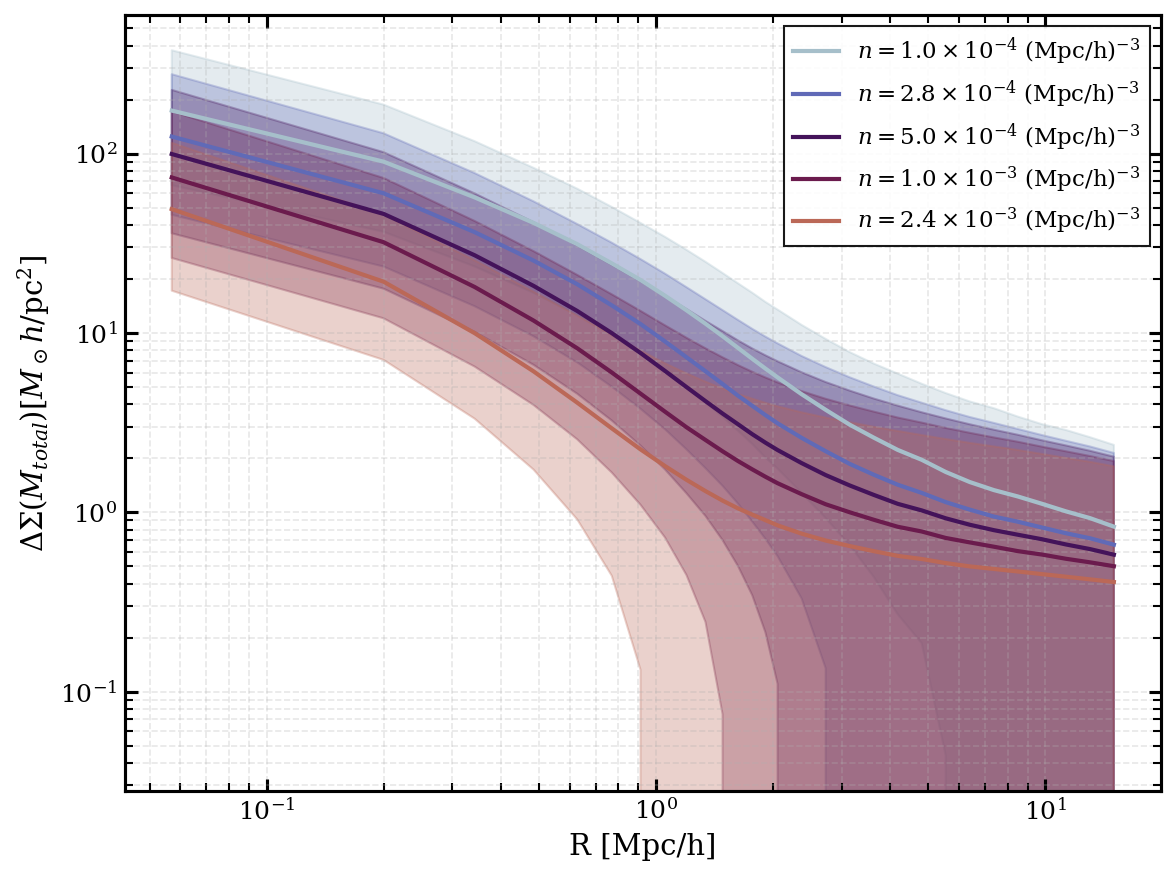

In [ ]:
# Volume of the simulation box
box_volume = 50**3  # (Mpc/h)^3

# Number densities to plot
number_densities_to_plot = [1.0e-4, 2.8e-4, 5e-4, 1.0e-3, 2.4e-3]

# Calculate number of halos for each density
n_halos_per_density = [int(nd * box_volume) for nd in number_densities_to_plot]
print("Number of halos for each density:", n_halos_per_density)

# Extract colors from prop_cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
cycle_colors = prop_cycle.by_key()['color']

# Get radial bins
radii = r1_mpch  # in Mpc/h

# Number density labels
nd_labels = [
    r'$n = 1.0 \times 10^{-4}$ (Mpc/h)$^{-3}$',
    r'$n = 2.8 \times 10^{-4}$ (Mpc/h)$^{-3}$',
    r'$n = 5.0 \times 10^{-4}$ (Mpc/h)$^{-3}$',
    r'$n = 1.0 \times 10^{-3}$ (Mpc/h)$^{-3}$',
    r'$n = 2.4 \times 10^{-3}$ (Mpc/h)$^{-3}$'
]
nd_colors = [cycle_colors[i] for i in range(5)]

fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH_SINGLE, 6))

# For each number density
for nd_idx, (n_halos, nd_label) in enumerate(zip(n_halos_per_density, nd_labels)):
    # Collect profiles from all simulations for this number density
    all_profiles_this_nd = []
    
    for sim_id in range(len(delta_sigma_xy_profiles_all_sims)):
        # Select first n_halos (halos are already sorted by descending mass)
        # Collect profiles from all three projections
        profiles_xy = delta_sigma_xy_profiles_all_sims[sim_id][:, :n_halos]
        profiles_xz = delta_sigma_xz_profiles_all_sims[sim_id][:, :n_halos]
        profiles_yz = delta_sigma_yz_profiles_all_sims[sim_id][:, :n_halos]
        
        # Concatenate along the halo dimension
        profiles_this_nd = np.concatenate([profiles_xy, profiles_xz, profiles_yz], axis=1)
        all_profiles_this_nd.append(profiles_this_nd)
    
    if len(all_profiles_this_nd) > 0:
        # Concatenate all profiles across all simulations
        all_profiles_concatenated = np.concatenate(all_profiles_this_nd, axis=1)
        all_profiles_concatenated *= 1e-6  # Convert from kpc^-2 to pc^-2
        
        # Calculate median and percentiles
        median_profile = np.nanmedian(all_profiles_concatenated, axis=1)
        p16_profile = np.nanpercentile(all_profiles_concatenated, 16, axis=1)
        p84_profile = np.nanpercentile(all_profiles_concatenated, 84, axis=1)
        
        # Filter for r >= 1 arcmin
        r_mask = radii[:len(median_profile)] >= 1.0
        
        # Plot median with shaded region
        ax.plot(radii[:len(median_profile)][r_mask], median_profile[r_mask], 
               color=nd_colors[nd_idx], linewidth=2, 
               label=nd_label)
        ax.fill_between(radii[:len(median_profile)][r_mask], 
                       p16_profile[r_mask], 
                       p84_profile[r_mask], 
                       color=nd_colors[nd_idx], alpha=0.3)
        
        print(f"Number density {nd_idx}: {all_profiles_concatenated.shape[1]} total halo profiles (from {len(all_profiles_this_nd)} sims × 3 projections × {n_halos} halos)")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [Mpc/h]')
ax.set_ylabel(r'$\Delta \Sigma (M_{total}) [M_\odot h / \mathrm{pc}^2]$')
ax.legend(loc='upper right')
ax.grid(True, which='both')


fig.tight_layout()
fig.savefig(FIG_SAVE_DIR + 'DeltaSigma_profiles_by_number_density.pdf', bbox_inches='tight', dpi=FIG_SAVE_DPI)
plt.show()

Number density 0: 36864 total halo profiles (from 1024 sims × 3 projections × 12 halos)
Number density 1: 107520 total halo profiles (from 1024 sims × 3 projections × 35 halos)
Number density 2: 190464 total halo profiles (from 1024 sims × 3 projections × 62 halos)
Number density 2: 190464 total halo profiles (from 1024 sims × 3 projections × 62 halos)
Number density 3: 384000 total halo profiles (from 1024 sims × 3 projections × 125 halos)
Number density 3: 384000 total halo profiles (from 1024 sims × 3 projections × 125 halos)
Number density 4: 921600 total halo profiles (from 1024 sims × 3 projections × 300 halos)
Number density 4: 921600 total halo profiles (from 1024 sims × 3 projections × 300 halos)


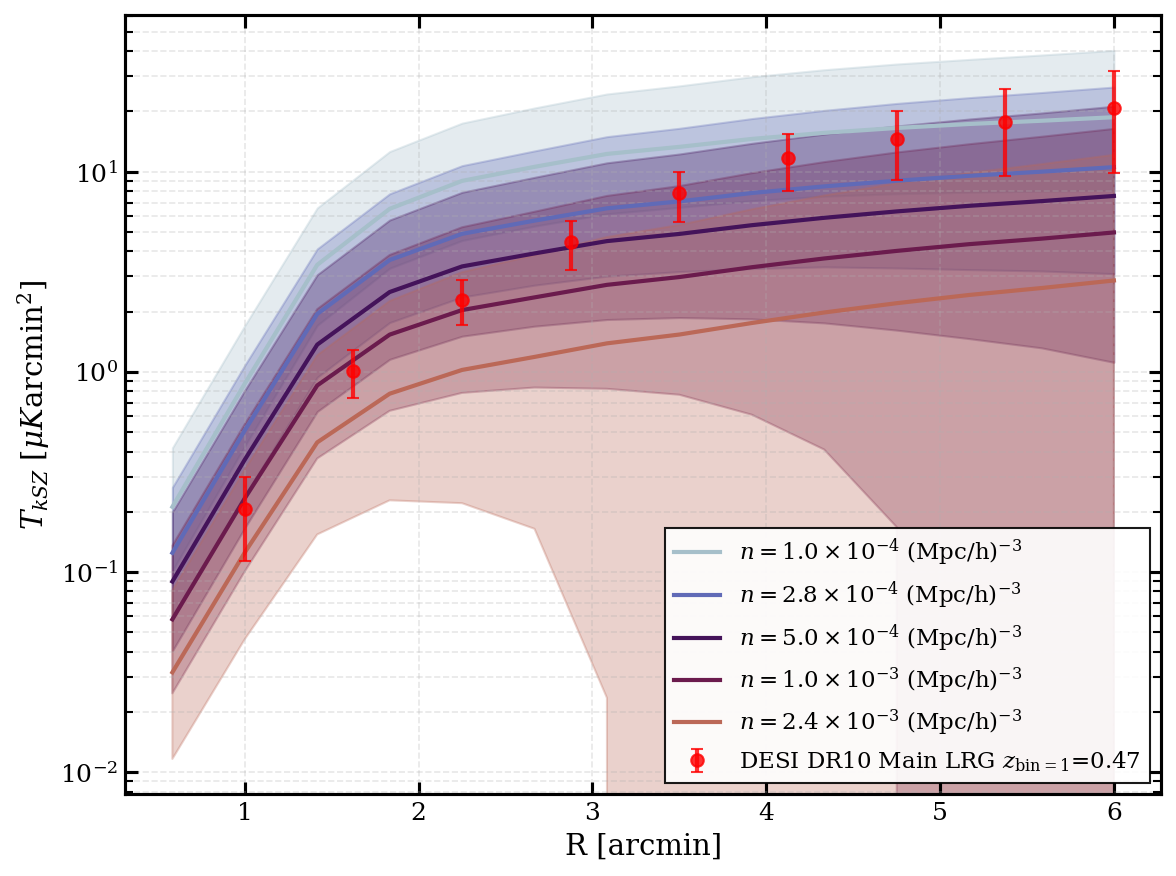

In [ ]:
# T_kSZ profiles by number density
# Get radial bins
radii = r0_arcmin  # in arcmin

# Extract colors from prop_cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
cycle_colors = prop_cycle.by_key()['color']
DESI_data = np.load('Fig1_Fig8_dr10_allfoot_perbin_sigmaz0.0500_dr6_corr_pzbin1.npz')

# Number density labels
nd_labels = [
    r'$n = 1.0 \times 10^{-4}$ (Mpc/h)$^{-3}$',
    r'$n = 2.8 \times 10^{-4}$ (Mpc/h)$^{-3}$',
    r'$n = 5.0 \times 10^{-4}$ (Mpc/h)$^{-3}$',
    r'$n = 1.0 \times 10^{-3}$ (Mpc/h)$^{-3}$',
    r'$n = 2.4 \times 10^{-3}$ (Mpc/h)$^{-3}$'
]
nd_colors = [cycle_colors[i] for i in range(5)]

fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH_SINGLE, 6))

# For each number density
for nd_idx, (n_halos, nd_label) in enumerate(zip(n_halos_per_density, nd_labels)):
    # Collect profiles from all simulations for this number density
    all_profiles_this_nd = []
    
    for sim_id in range(len(ksz_profiles_xy_all_sims)):
        # Select first n_halos (halos are already sorted by descending mass)
        # Collect profiles from all three projections
        profiles_xy = ksz_profiles_xy_all_sims[sim_id][:, :n_halos]
        profiles_xz = ksz_profiles_xz_all_sims[sim_id][:, :n_halos]
        profiles_yz = ksz_profiles_yz_all_sims[sim_id][:, :n_halos]
        
        # Concatenate along the halo dimension
        profiles_this_nd = np.concatenate([profiles_xy, profiles_xz, profiles_yz], axis=1)
        all_profiles_this_nd.append(profiles_this_nd)
    
    if len(all_profiles_this_nd) > 0:
        # Concatenate all profiles across all simulations
        all_profiles_concatenated = np.concatenate(all_profiles_this_nd, axis=1)
        
        # Calculate median and percentiles
        median_profile = np.nanmedian(all_profiles_concatenated, axis=1)
        p16_profile = np.nanpercentile(all_profiles_concatenated, 16, axis=1)
        p84_profile = np.nanpercentile(all_profiles_concatenated, 84, axis=1)
        
        # Filter for r >= 1 arcmin
        r_mask = radii[:len(median_profile)] >= 0.5
        
        # Plot median with shaded region
        ax.plot(radii[:len(median_profile)][r_mask], median_profile[r_mask], 
               color=nd_colors[nd_idx], linewidth=2, 
               label=nd_label)
        ax.fill_between(radii[:len(median_profile)][r_mask], 
                       p16_profile[r_mask], 
                       p84_profile[r_mask], 
                       color=nd_colors[nd_idx], alpha=0.3)
        
        print(f"Number density {nd_idx}: {all_profiles_concatenated.shape[1]} total halo profiles (from {len(all_profiles_this_nd)} sims × 3 projections × {n_halos} halos)")
ax.errorbar(DESI_data['theta_arcmins'], DESI_data['prof'], 
           yerr=np.sqrt(DESI_data['cov'].diagonal()), 
           fmt='o', 
           color='r', alpha=0.8,
           label=r'DESI DR10 Main LRG $z_{\rm{bin}=1}$=0.47', zorder=5)
ax.set_xlabel('R [arcmin]')
ax.set_ylabel(r'$T_{kSZ}$ [$\mu K \rm{arcmin}^2$]')
ax.set_yscale('log')
ax.legend(loc='lower right')
ax.grid(True, which='both')


fig.tight_layout()
plt.show()
fig.savefig(FIG_SAVE_DIR + 'kSZ_profiles_by_number_density.pdf', bbox_inches='tight', dpi=FIG_SAVE_DPI)


# T_ksz vs. SP(k) 

### P(k)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
base_path_template = '/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{}/data/'
all_sims_pk_data = []

# Load data for all simulations
sims = np.arange(1024)
for sim_id in sims:
    profile_file = base_path_template.format(sim_id) + 'Pk_512_3Dfield.npz'  # Update filename
    loaded_data = np.load(profile_file)
    all_sims_pk_data.append(loaded_data)
    
    # Print keys from first simulation to see what's available
    if sim_id == sims[0]:
        print("Keys in the power spectrum file:")
        for key in loaded_data.keys():
            print(f"  {key}")

# Compute suppression ratios for all simulations
k = all_sims_pk_data[0]['k']*1e3 # Convert from h/kpc to h/Mpc
Ptot_Pdm_ratio = []
for pk_data in all_sims_pk_data:
    suppression = pk_data['P_tot'] / pk_data['P_dm']
    Ptot_Pdm_ratio.append(suppression)

Ptot_Pdm_ratio = np.array(Ptot_Pdm_ratio)

Keys in the power spectrum file:
  k
  PX_dm_tot
  P_dm
  P_tot
  r
  XX_dm_tot
  X_dm
  X_tot


k=10 closest to k=9.989 (index 78)
Mean SP(k) range: 0.5157 to 1.2627


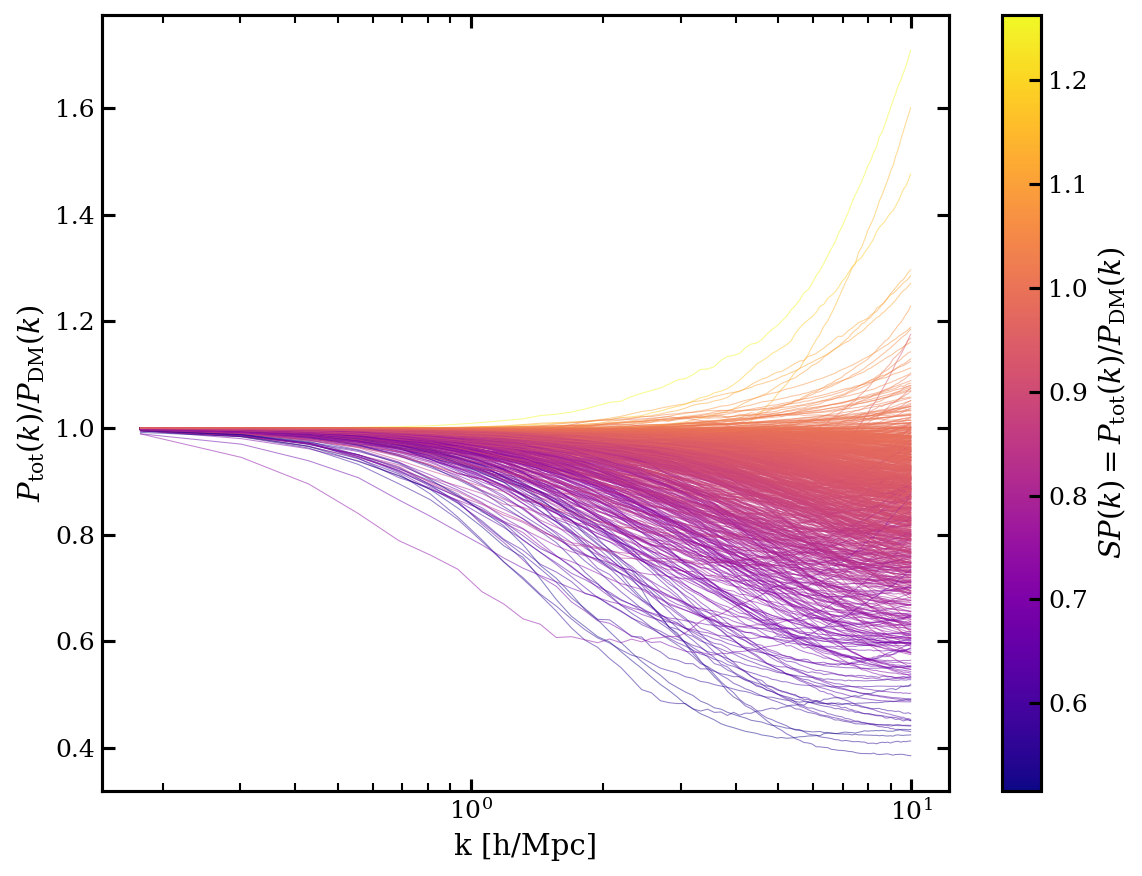

In [5]:
# Plot Ptot_Pdm_ratio with plasma colormap for k<=10
k_max_idx = np.argmin(np.abs(k - 10.0))
print(f"k=10 closest to k={k[k_max_idx]:.3f} (index {k_max_idx})")

# Calculate mean SP(k) for each simulation (over k range)
mean_sp_values = np.mean(Ptot_Pdm_ratio[:, :k_max_idx+1], axis=1)

# Sort simulations by mean SP(k) value
sorted_indices = np.argsort(mean_sp_values)
min_sp = mean_sp_values.min()
max_sp = mean_sp_values.max()

print(f"Mean SP(k) range: {min_sp:.4f} to {max_sp:.4f}")

fig, ax = plt.subplots(figsize=(FIG_WIDTH_SINGLE, 6))

# Plot each simulation's suppression ratio, colored by mean SP(k) value
for sim_idx in range(len(Ptot_Pdm_ratio)):
    # Map mean SP(k) value to color (normalized between min and max)
    color_val = (mean_sp_values[sim_idx] - min_sp) / (max_sp - min_sp)
    color = plt.cm.plasma(color_val)
    ax.plot(k[:k_max_idx+1], Ptot_Pdm_ratio[sim_idx, :k_max_idx+1], 
            color=color, alpha=0.5, linewidth=0.5)

# Create a scalar mappable for the colorbar with mean SP(k) values
sm = plt.cm.ScalarMappable(cmap='plasma', 
                           norm=plt.Normalize(vmin=min_sp, vmax=max_sp))
sm.set_array([])
im = sm

ax.set_xlabel('k [h/Mpc]')
ax.set_xscale('log')
ax.set_ylabel(r'$P_{\rm tot}(k) / P_{\rm DM}(k)$')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$SP(k) = P_{\rm tot}(k) / P_{\rm DM}(k)$')

fig.tight_layout()
plt.show()
fig.savefig(FIG_SAVE_DIR + 'Ptot_Pdm_ratio.pdf', bbox_inches='tight', dpi=FIG_SAVE_DPI)

### Scatter Plot

k=0.3 closest to k=0.302, k=1 closest to k=1.062
θ=3 arcmin closest to θ=3.083 arcmin (index 7)
Bigwoods Bin 0: 130 halos in all simulations
Bigwoods Bin 1: 531 halos in all simulations
Bigwoods Bin 2: 1014 halos in all simulations
Bigwoods Bin 3: 1019 halos in all simulations
Bigwoods Bin 4: 921 halos in all simulations


Bigwoods Bin 5: 487 halos in all simulations


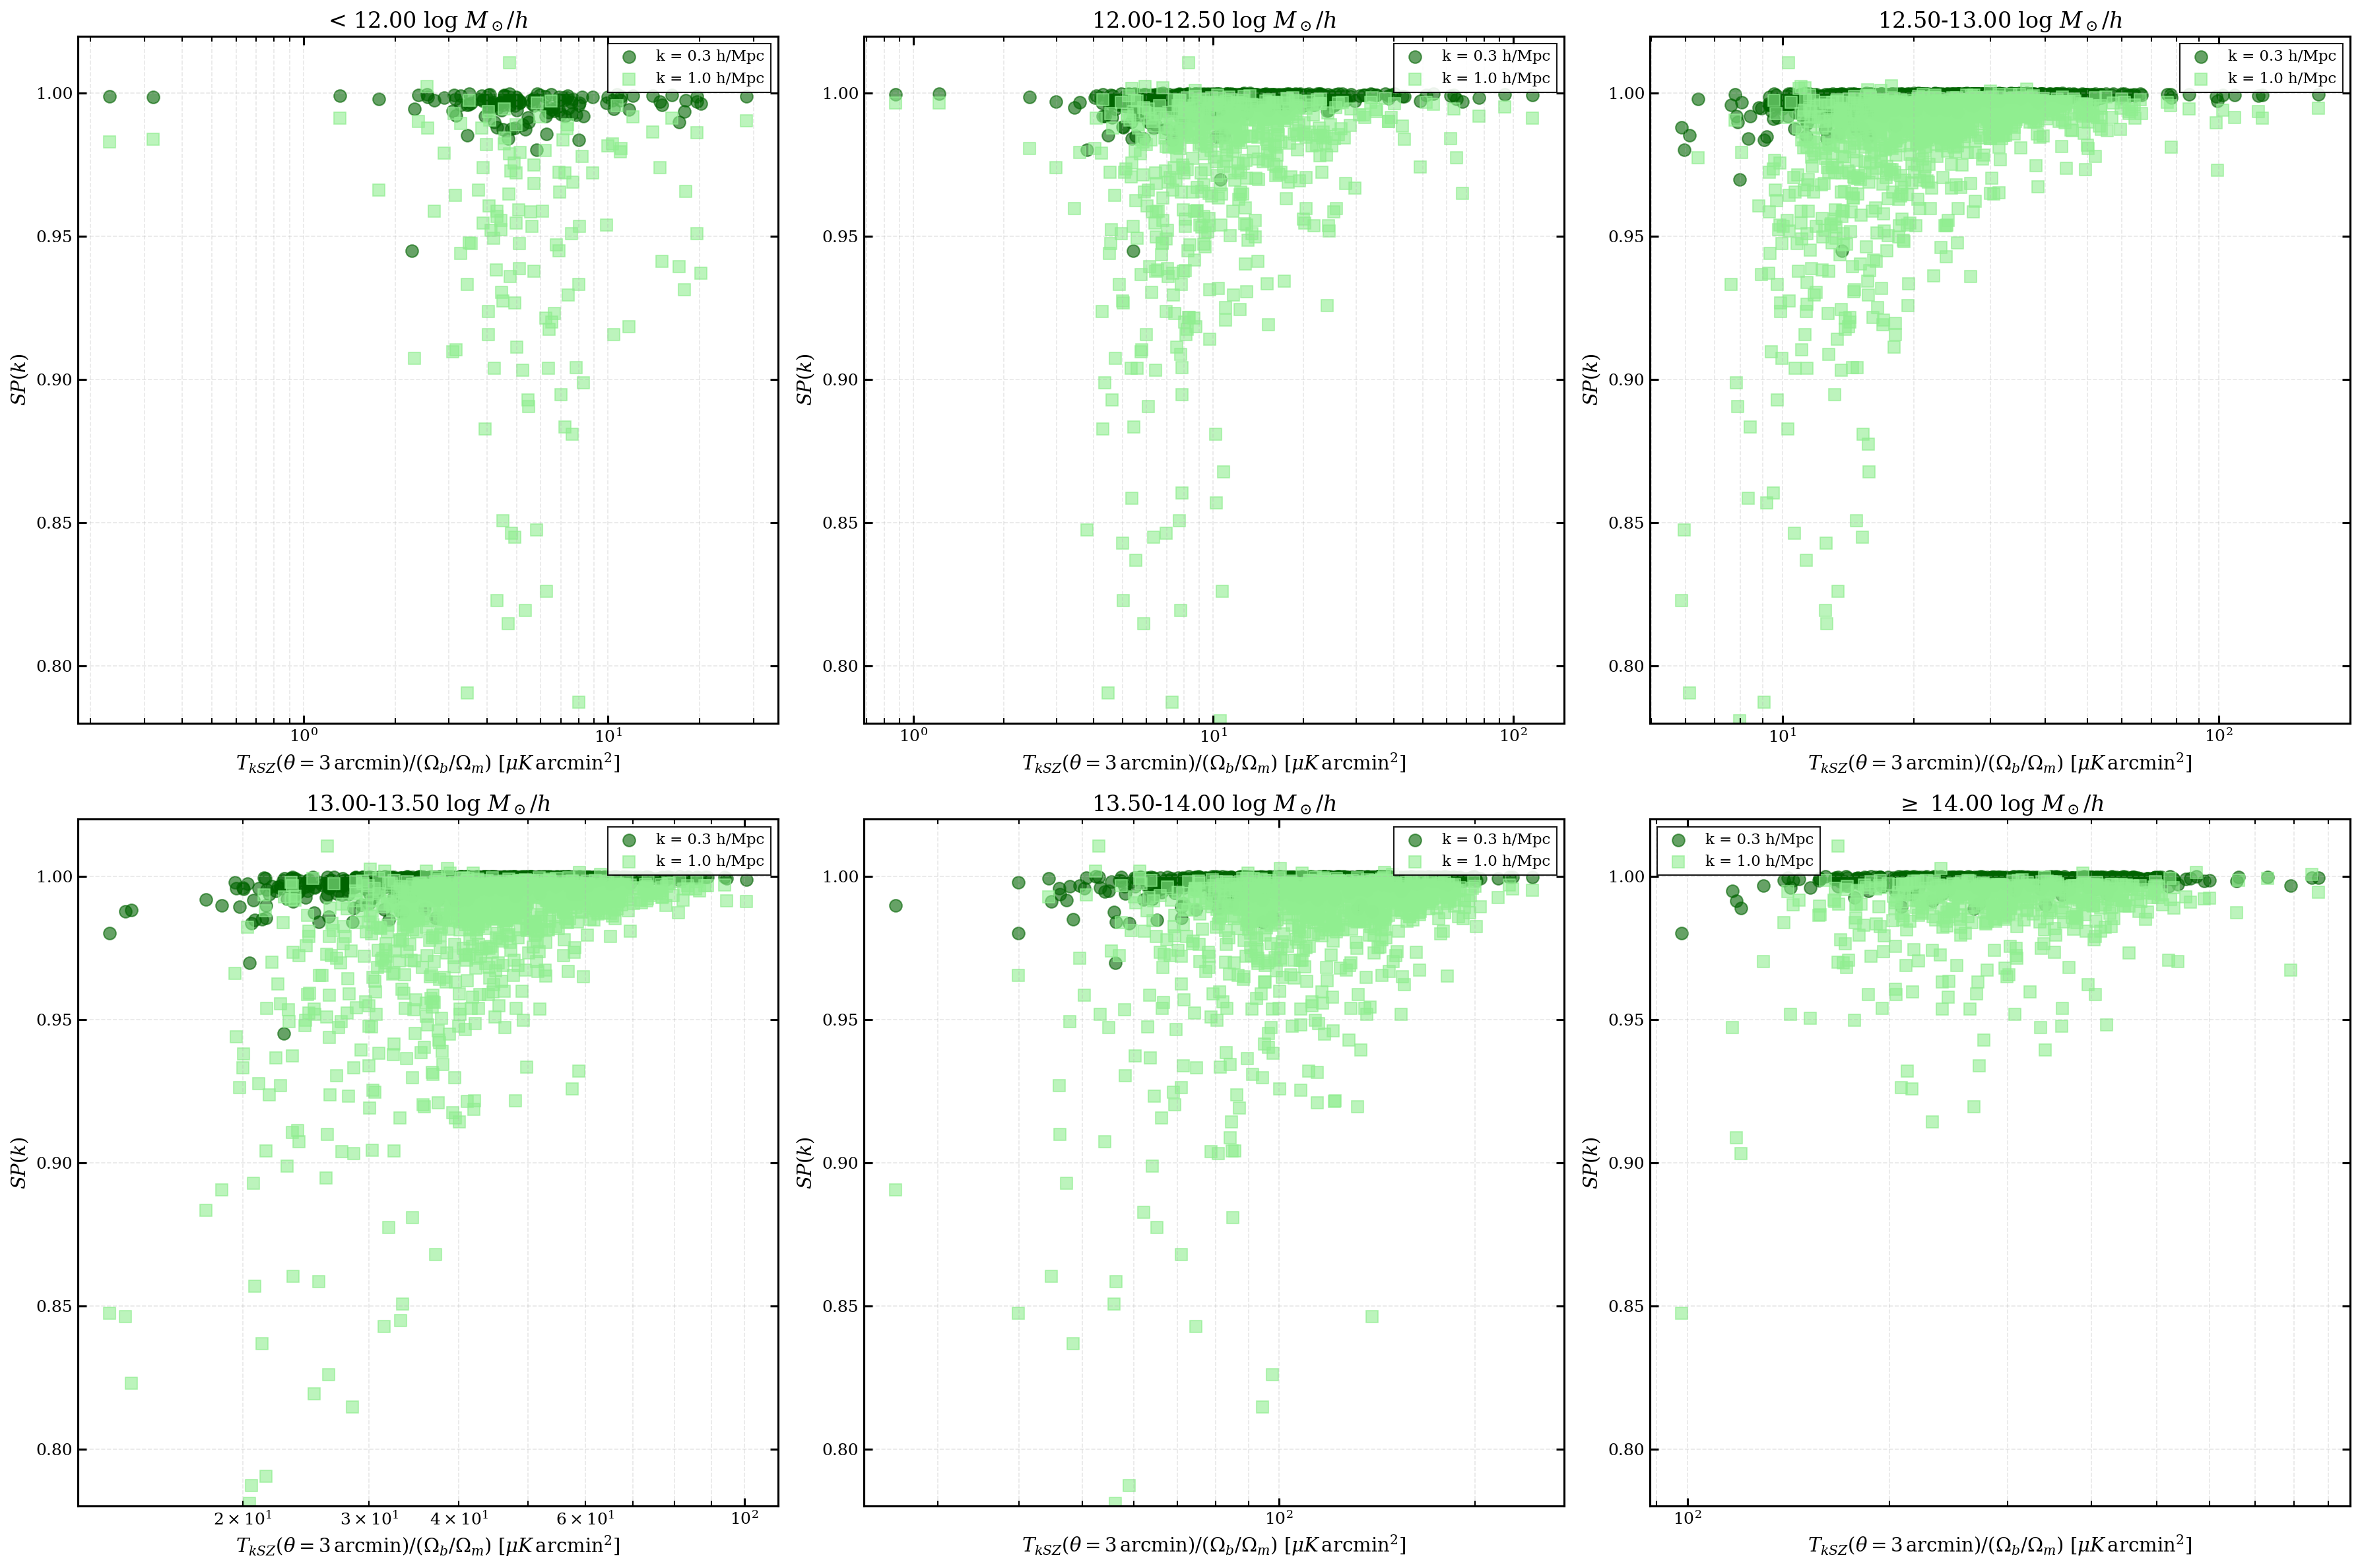

In [10]:
# Recreate plot matching the image format: kSZ at θ=3 arcmin vs SP(k)

# Get radial bins
radii = r0_arcmin  # in arcmin

# Mass bin labels for Bigwoods binning - 6 bins total
bigwoods_mass_bin_labels = [
    r'< 12.00 log $M_\odot/h$',
    r'12.00-12.50 log $M_\odot/h$',
    r'12.50-13.00 log $M_\odot/h$',
    r'13.00-13.50 log $M_\odot/h$',
    r'13.50-14.00 log $M_\odot/h$',
    r'$\geq$ 14.00 log $M_\odot/h$'
]

# Get SP(k) values at k=0.3 and k=1

k_03_idx = np.argmin(np.abs(k - 0.3 ))
k_1_idx = np.argmin(np.abs(k - 1.0))

print(f"k=0.3 closest to k={k[k_03_idx]:.3f}, k=1 closest to k={k[k_1_idx]:.3f}")

# Find index closest to θ=3 arcmin
theta_3arcmin_idx = np.argmin(np.abs(radii - 3.0))
print(f"θ=3 arcmin closest to θ={radii[theta_3arcmin_idx]:.3f} arcmin (index {theta_3arcmin_idx})")

fig, axes = plt.subplots(2, 3, figsize=(FIG_WIDTH_SINGLE*3, FIG_WIDTH_GRID))
axes = axes.flatten()

# Process each mass bin (6 bins: 0, 1, 2, 3, 4, 5)
for mass_bin_idx in range(6):
    ax = axes[mass_bin_idx]
    
    # Collect kSZ at θ=3 arcmin and SP(k) values for each simulation
    ksz_at_3arcmin_list = []
    sp_k03_list = []
    sp_k1_list = []
    
    for sim_id in range(len(ksz_profiles_xy_all_sims)):
        sim_profiles_xy = ksz_profiles_xy_all_sims[sim_id][:,:62]
        sim_profiles_xz = ksz_profiles_xz_all_sims[sim_id][:,:62]
        sim_profiles_yz = ksz_profiles_yz_all_sims[sim_id][:,:62]
        
        bin_indices = ksz_halo_bigwoods_mass_bin_idx_all_sims[sim_id][:62]
        mask= (bin_indices == mass_bin_idx)
        fb = fb_all_sims[sim_id]
        
        if np.sum(mask) > 0:
            # Calculate median kSZ at θ=3 arcmin for this simulation's halos in this mass bin
            profiles_xy = sim_profiles_xy[:, mask]
            profiles_xz = sim_profiles_xz[:, mask]
            profiles_yz = sim_profiles_yz[:, mask]
            profiles_this_bin = np.concatenate([profiles_xy, profiles_xz, profiles_yz], axis=1) #sim_profiles[:, mask]
            median_ksz_at_3arcmin = np.nanmean(profiles_this_bin[theta_3arcmin_idx, :])
            ksz_at_3arcmin_list.append(median_ksz_at_3arcmin/fb)
            
            # Get SP(k) for this simulation
            sp_ratio = Ptot_Pdm_ratio[sim_id]
            sp_k03_list.append(sp_ratio[k_03_idx])
            sp_k1_list.append(sp_ratio[k_1_idx])

            # Get kSZ at θ=3 arcmin for all halos in this mass bin
            # ksz_values = profiles_this_bin[theta_3arcmin_idx, :] / fb
            # n_halos = len(ksz_values)
            
            # # Append all individual halo values
            # ksz_at_3arcmin_list.extend(ksz_values)
            
            # # Get SP(k) for this simulation and repeat for each halo
            # sp_ratio = Ptot_Pdm_ratio[sim_id]
            # sp_k03_list.extend([sp_ratio[k_03_idx]] * n_halos)
            # sp_k1_list.extend([sp_ratio[k_1_idx]] * n_halos)

            
    # Scatter plot: kSZ at θ=3 arcmin (x-axis) vs SP(k) (y-axis)
    # Dark green for k=0.3
    ax.scatter(ksz_at_3arcmin_list, sp_k03_list, 
              color='darkgreen', marker='o', s=80, alpha=0.6, 
              label=f'k = 0.3 h/Mpc')
    
    # Light green for k=1
    ax.scatter(ksz_at_3arcmin_list, sp_k1_list, 
              color='lightgreen', marker='s', s=80, alpha=0.6, 
              label=f'k = 1.0 h/Mpc')
    
    print(f"Bigwoods Bin {mass_bin_idx}: {len(ksz_at_3arcmin_list)} halos in all simulations")
    
    # Set labels and formatting
    ax.set_xlabel(r'$T_{kSZ}(\theta=3\,\mathrm{arcmin})/(\Omega_b/\Omega_m)$ [$\mu K \, \mathrm{arcmin}^2$]')
    ax.set_ylabel(r'$SP(k)$')
    ax.set_xscale('log')
    
    ax.set_ylim(0.78, 1.02)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3, which='both')
    ax.set_title(f'{bigwoods_mass_bin_labels[mass_bin_idx]}')

# fig.suptitle(r'Bigwood et al. 2025 Fig. 8', fontsize=18, y=0.995)
fig.tight_layout()
plt.show()
fig.savefig(FIG_SAVE_DIR + 'kSZ_3arcmin_vs_SP.pdf', bbox_inches='tight', dpi=FIG_SAVE_DPI)


# Ratio vs. SP(k)

In [16]:


def plot_ratio_vs_suppression(k_value1=1.0, k_value2=10.0, theta_arcmin_value1=6.0, theta_arcmin_value2=None):
    """
    Plot T_kSZ/Delta Sigma ratio vs power spectrum suppression SP(k).
    
    Parameters:
    -----------
    k_value1 : float
        First k-value in h/Mpc (default: 1.0)
    k_value2 : float
        Second k-value in h/Mpc (default: 10.0)
    theta_arcmin_value1 : float
        First angular scale in arcmin to evaluate profiles (default: 6.0)
    theta_arcmin_value2 : float, optional
        Second angular scale in arcmin. If provided, x-axis will be the difference
        (larger - smaller) between ratios at the two angular scales (default: None)
    """
    # Mass bin labels for Bigwoods binning - 6 bins total
    bigwoods_mass_bin_labels = [
        r'< 12.00 log $M_\odot/h$',
        r'12.00-12.50 log $M_\odot/h$',
        r'12.50-13.00 log $M_\odot/h$',
        r'13.00-13.50 log $M_\odot/h$',
        r'13.50-14.00 log $M_\odot/h$',
        r'$\geq$ 14.00 log $M_\odot/h$'
    ]

    # Get SP(k) values at specified k-values
    k1_idx = np.argmin(np.abs(k - k_value1))
    k2_idx = np.argmin(np.abs(k - k_value2))

    print(f"k={k_value1} closest to k={k[k1_idx]:.3f}, k={k_value2} closest to k={k[k2_idx]:.3f}")
    
    # Determine if we're plotting difference or single value
    if theta_arcmin_value2 is not None:
        # Ensure larger - smaller for positive difference
        theta_large = max(theta_arcmin_value1, theta_arcmin_value2)
        theta_small = min(theta_arcmin_value1, theta_arcmin_value2)
        print(f"Using θ difference: {theta_large:.1f} - {theta_small:.1f} arcmin")
        use_difference = True
    else:
        print(f"Using θ={theta_arcmin_value1} arcmin")
        use_difference = False

    fig, axes = plt.subplots(2, 3, figsize=(FIG_WIDTH_DOUBLE, 12))
    axes = axes.flatten()

    # Process each mass bin (6 bins: 0, 1, 2, 3, 4, 5)
    for mass_bin_idx in range(6):
        ax = axes[mass_bin_idx]
        
        # Collect T_kSZ/Delta Sigma ratio at specified theta and SP(k) values for each simulation
        ksz_dsigma_ratio_list = []
        sp_k1_list = []
        sp_k2_list = []
        
        for sim_id in range(len(ksz_profiles_xy_all_sims)):
            bin_indices = ksz_halo_bigwoods_mass_bin_idx_all_sims[sim_id]
            mask = np.zeros_like(bin_indices)
            mask[:62] = (bin_indices == mass_bin_idx)[:62]
            fb = fb_all_sims[sim_id]
            
            if np.sum(mask) > 0:
                # Calculate median kSZ at θ=3 arcmin for this simulation's halos in this mass bin
                profiles_xy =  ksz_profiles_xy_all_sims[sim_id][:, mask]
                profiles_xz =  ksz_profiles_xz_all_sims[sim_id][:, mask]
                profiles_yz =  ksz_profiles_yz_all_sims[sim_id][:, mask]
                
                # Concatenate kSZ profiles from all projections
                ksz_profiles_this_bin = np.concatenate([profiles_xy, profiles_xz, profiles_yz], axis=1)
                
                # For Delta Sigma, check if arcmin versions exist for all projections
                # If not, use only xy projection
                if (delta_sigma_arcmin_xz_profiles_all_sims[sim_id] is not None and 
                    delta_sigma_arcmin_yz_profiles_all_sims[sim_id] is not None):
                    # All projections available in arcmin
                    dsigma_profiles_xy = delta_sigma_arcmin_xy_profiles_all_sims[sim_id][:, mask]
                    dsigma_profiles_xz = delta_sigma_arcmin_xz_profiles_all_sims[sim_id][:, mask]
                    dsigma_profiles_yz = delta_sigma_arcmin_yz_profiles_all_sims[sim_id][:, mask]
                    dsigma_profiles_this_bin = np.concatenate([dsigma_profiles_xy, dsigma_profiles_xz, dsigma_profiles_yz], axis=1)
                else:
                    # Only xy projection available, replicate it for each kSZ halo
                    # Since we have 3x kSZ halos but only 1x dsigma, tile the dsigma profiles
                    dsigma_profiles_xy = delta_sigma_arcmin_xy_profiles_all_sims[sim_id][:, mask]
                    dsigma_profiles_this_bin = np.tile(dsigma_profiles_xy, 3)
                
                if use_difference:
                    # Calculate ratio at both angular scales
                    # For larger theta
                    theta_idx_ksz_large = np.argmin(np.abs(r0_arcmin_all_sims[sim_id] - theta_large))
                    theta_idx_dsigma_large = np.argmin(np.abs(r1_arcmin_all_sims[sim_id] - theta_large))
                    ratio_large = (ksz_profiles_this_bin[theta_idx_ksz_large, :] / fb) / dsigma_profiles_this_bin[theta_idx_dsigma_large, :]
                    
                    # For smaller theta
                    theta_idx_ksz_small = np.argmin(np.abs(r0_arcmin_all_sims[sim_id] - theta_small))
                    theta_idx_dsigma_small = np.argmin(np.abs(r1_arcmin_all_sims[sim_id] - theta_small))
                    ratio_small = (ksz_profiles_this_bin[theta_idx_ksz_small, :] / fb) / dsigma_profiles_this_bin[theta_idx_dsigma_small, :]
                    
                    # Calculate difference (larger - smaller)
                    ratio =  np.nanmedian(ratio_large - ratio_small)
                else:
                    # Single theta value
                    theta_idx_ksz = np.argmin(np.abs(r0_arcmin_all_sims[sim_id] - theta_arcmin_value1))
                    theta_idx_dsigma = np.argmin(np.abs(r1_arcmin_all_sims[sim_id] - theta_arcmin_value1))
                    ratio = np.nanmedian((ksz_profiles_this_bin[theta_idx_ksz, :] / fb) / 
                                        dsigma_profiles_this_bin[theta_idx_dsigma, :])
                
                ksz_dsigma_ratio_list.append(ratio)
                
                # Get SP(k) for this simulation
                sp_ratio = Ptot_Pdm_ratio[sim_id]
                sp_k1_list.append(sp_ratio[k1_idx])
                sp_k2_list.append(sp_ratio[k2_idx])
        
        if len(ksz_dsigma_ratio_list) > 0:
            
            # Scatter plot: T_kSZ/Delta Sigma ratio (x-axis) vs SP(k) (y-axis)
            ax.scatter(ksz_dsigma_ratio_list, sp_k1_list, 
                      color='darkgreen', marker='o', s=80, alpha=0.6, 
                      label=f'k = {k_value1} h/Mpc')
            
            ax.scatter(ksz_dsigma_ratio_list, sp_k2_list, 
                      color='lightgreen', marker='s', s=80, alpha=0.6, 
                      label=f'k = {k_value2} h/Mpc')
            
            # Set labels and formatting
            if use_difference:
                xlabel = (r'$\Delta[T_{kSZ}/\Delta\Sigma]/(\Omega_b/\Omega_m)$ ' + 
                         f'($\\theta={theta_large:.1f}-{theta_small:.1f}$ arcmin) ' +
                         r'[$\mu K \mathrm{arcmin}^4 / M_\odot h$]')
                title_text = f'{theta_large:.1f} - {theta_small:.1f} arcmin'
            else:
                xlabel = r'$[T_{kSZ}/\Delta\Sigma](\theta=' + f'{theta_arcmin_value1:.1f}' + r'\,\mathrm{arcmin})/(\Omega_b/\Omega_m)$ [$\mu K \mathrm{arcmin}^4 / M_\odot h$]'
                title_text = f'{theta_arcmin_value1:.1f} arcmin'
            
            ax.set_xlabel(xlabel)
            ax.set_ylabel(r'$SP(k)$')
            
            # Only use log scale if not using difference (difference can be negative)
            if not use_difference:
                ax.set_xscale('log')
            
            ax.set_ylim(0.78, 1.02)
            ax.legend(loc='best')
            ax.grid(True, which='both')
            ax.set_title(f'{bigwoods_mass_bin_labels[mass_bin_idx]}')

    fig.tight_layout()
    # Create filename based on parameters
    if use_difference:
        filename = f'ratio_vs_SP_theta_diff_{theta_large:.1f}_{theta_small:.1f}_k_{k_value1:.1f}_{k_value2:.1f}.pdf'
    else:
        filename = f'ratio_vs_SP_theta_{theta_arcmin_value1:.1f}_k_{k_value1:.1f}_{k_value2:.1f}.pdf'
    fig.savefig(FIG_SAVE_DIR + filename, bbox_inches='tight', dpi=FIG_SAVE_DPI)

    plt.show()# Call the function with default values (k=1.0, k=10.0, theta=6.0 arcmin)


k=0.3 closest to k=0.302, k=1.0 closest to k=1.062
Using θ difference: 3.0 - 1.0 arcmin


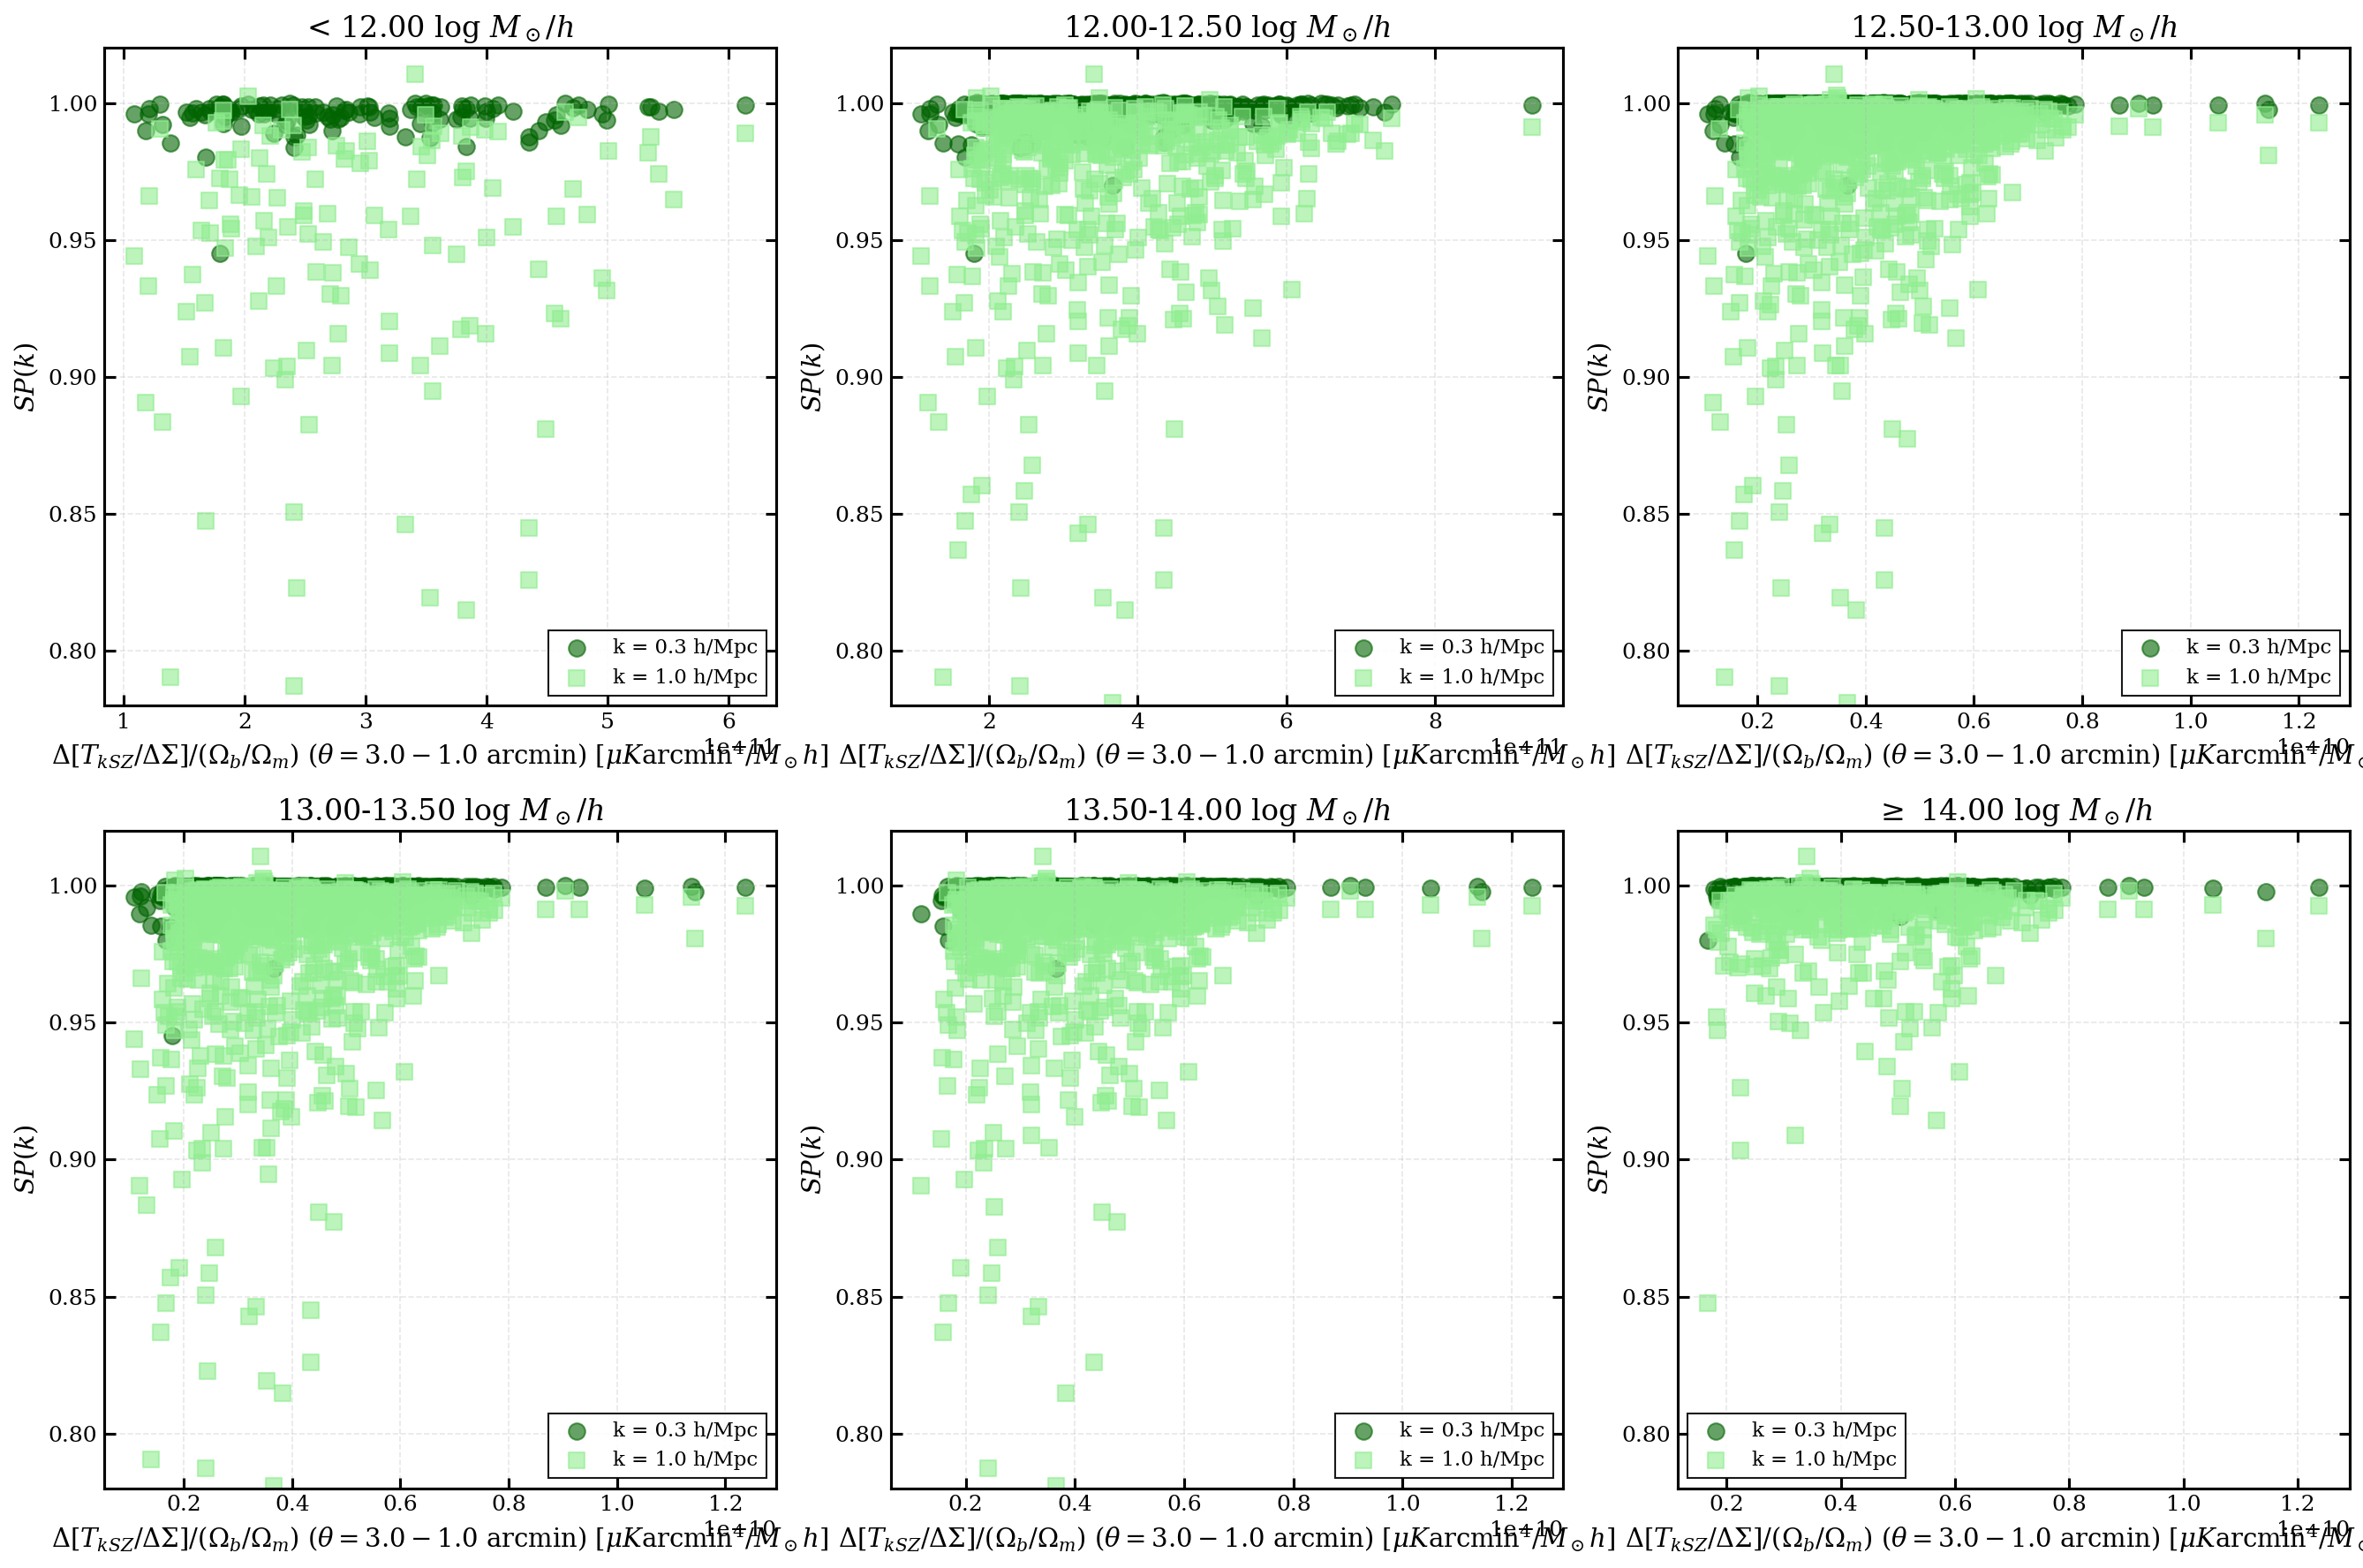

In [17]:
plot_ratio_vs_suppression(k_value1=0.3, k_value2=1.0, theta_arcmin_value1=1.0, theta_arcmin_value2=3.0)

k=0.3 closest to k=0.302, k=1 closest to k=1.062
Using θ=3.0 arcmin


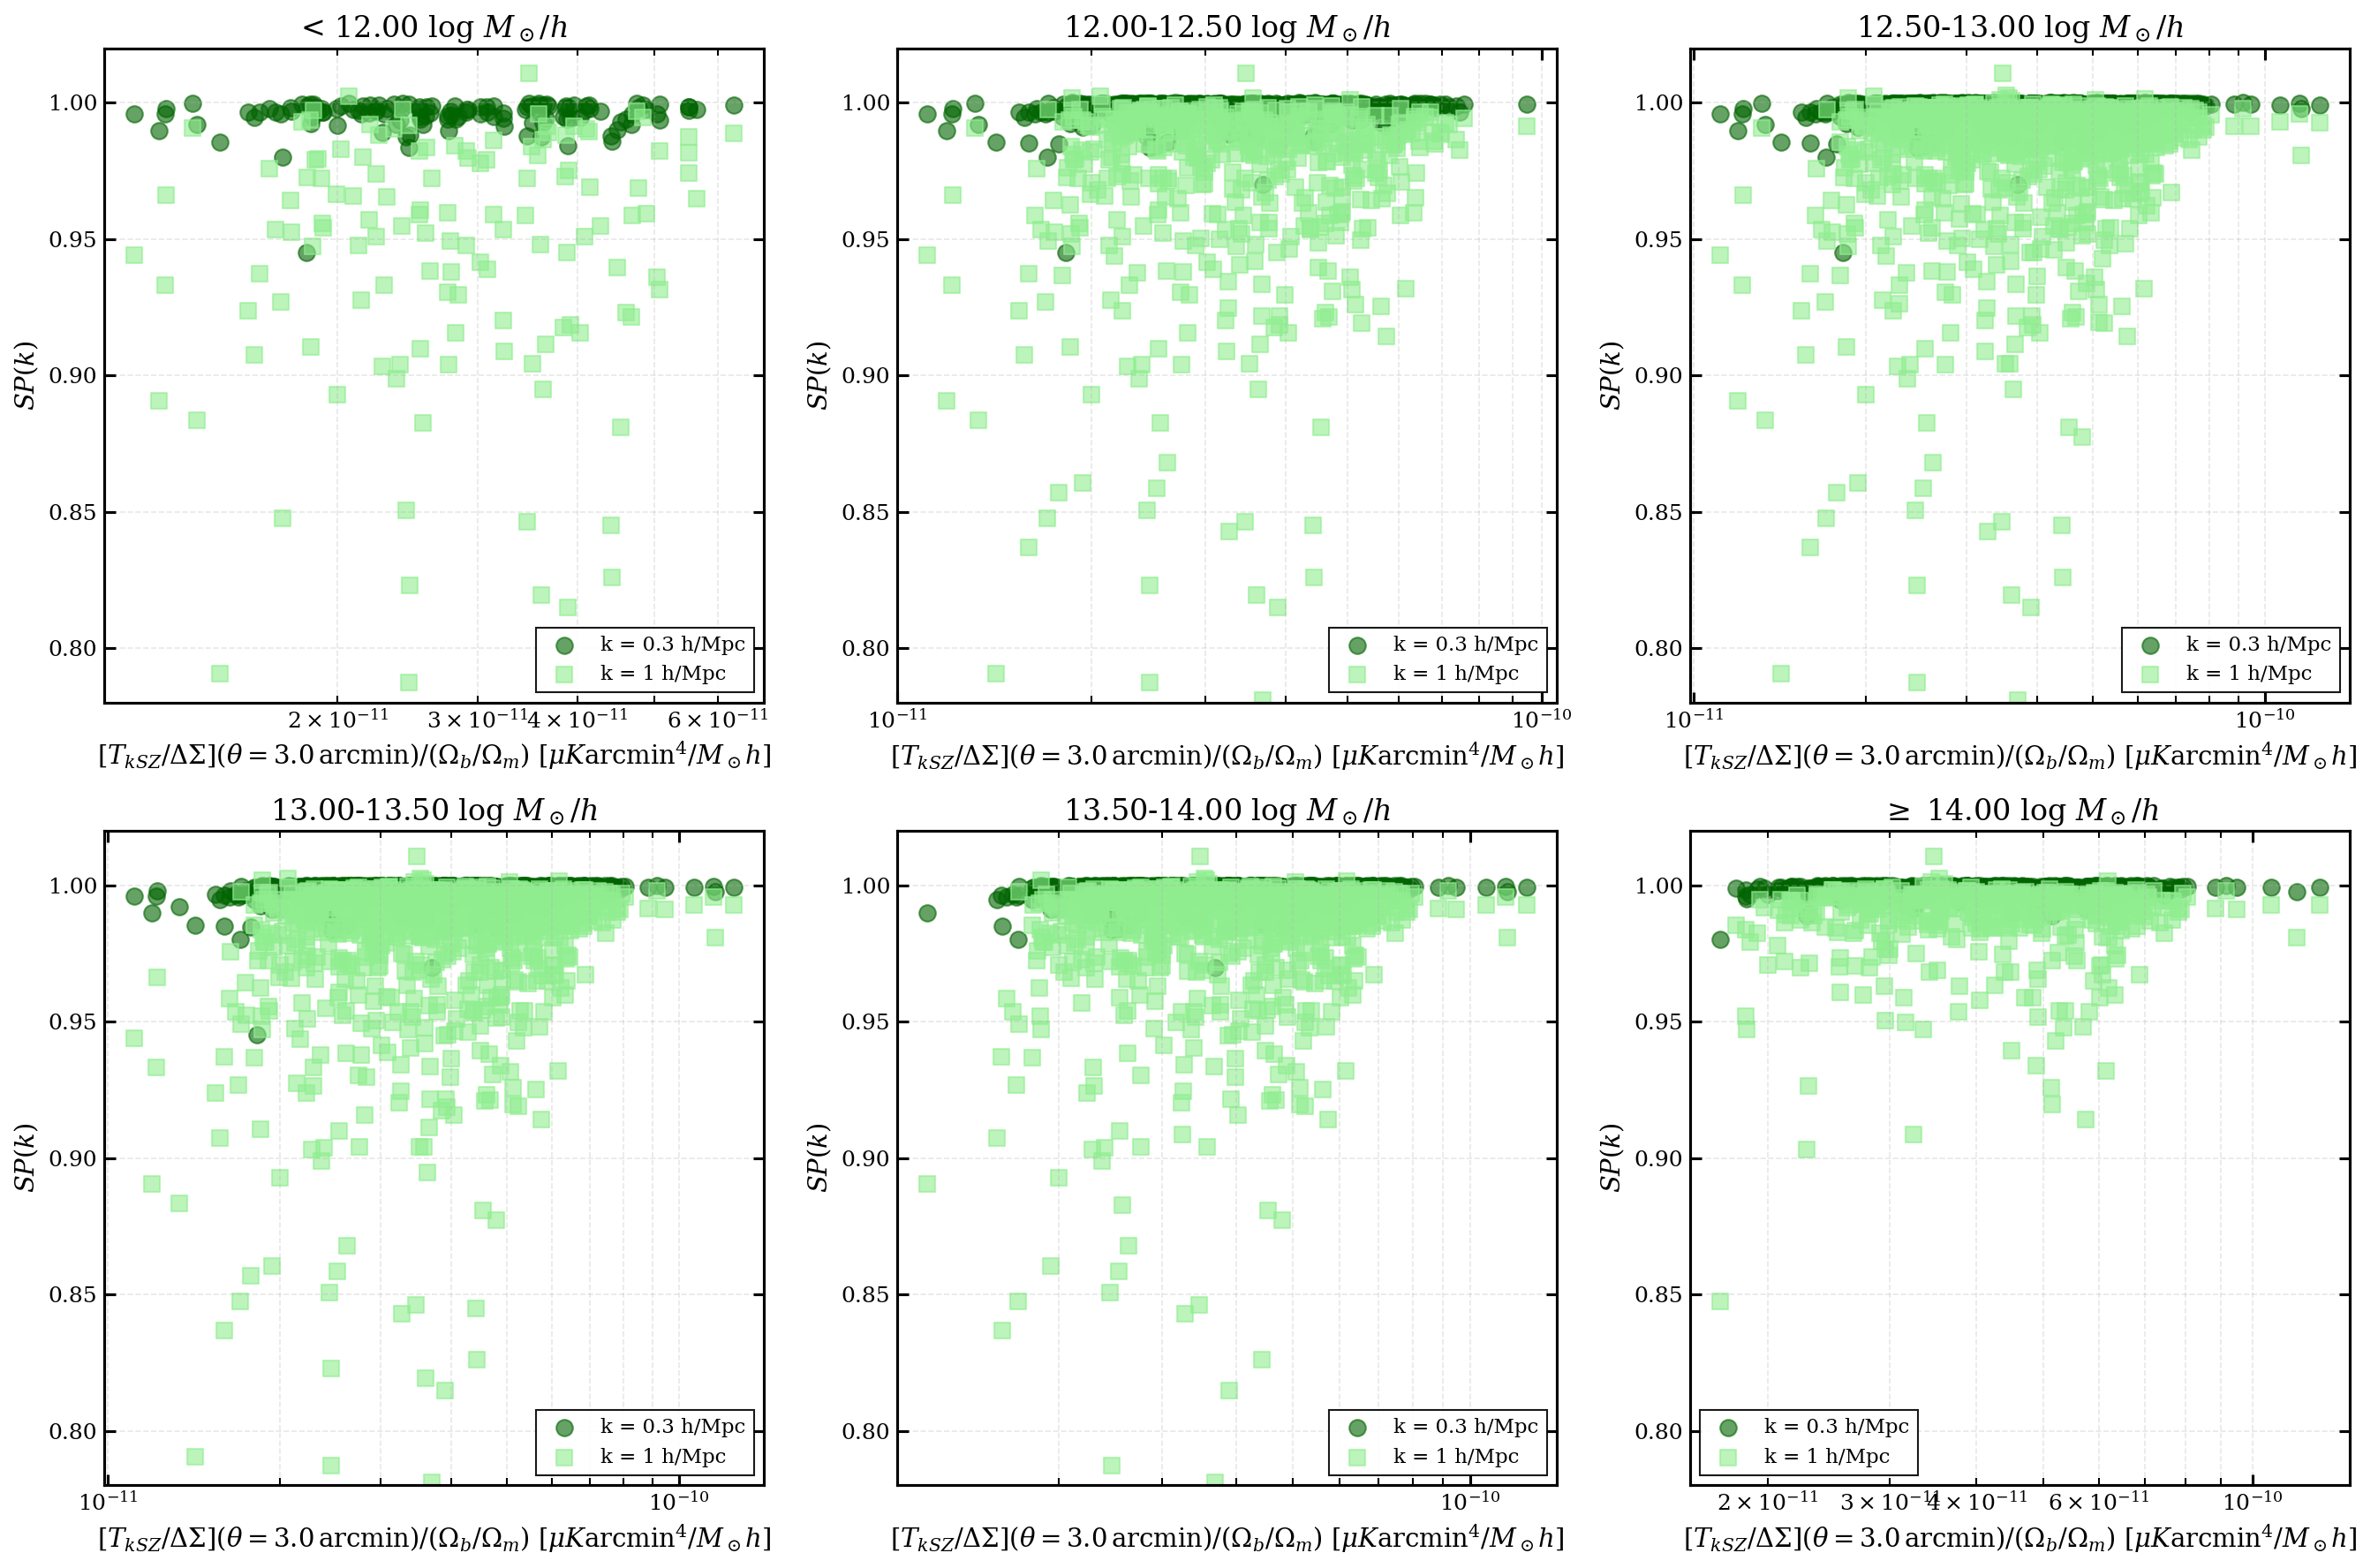

In [18]:
plot_ratio_vs_suppression(k_value1=0.3, k_value2=1, theta_arcmin_value1=3.0)

k=0.3 closest to k=0.302, k=1 closest to k=1.062
Using θ difference: 3.0 - 0.1 arcmin


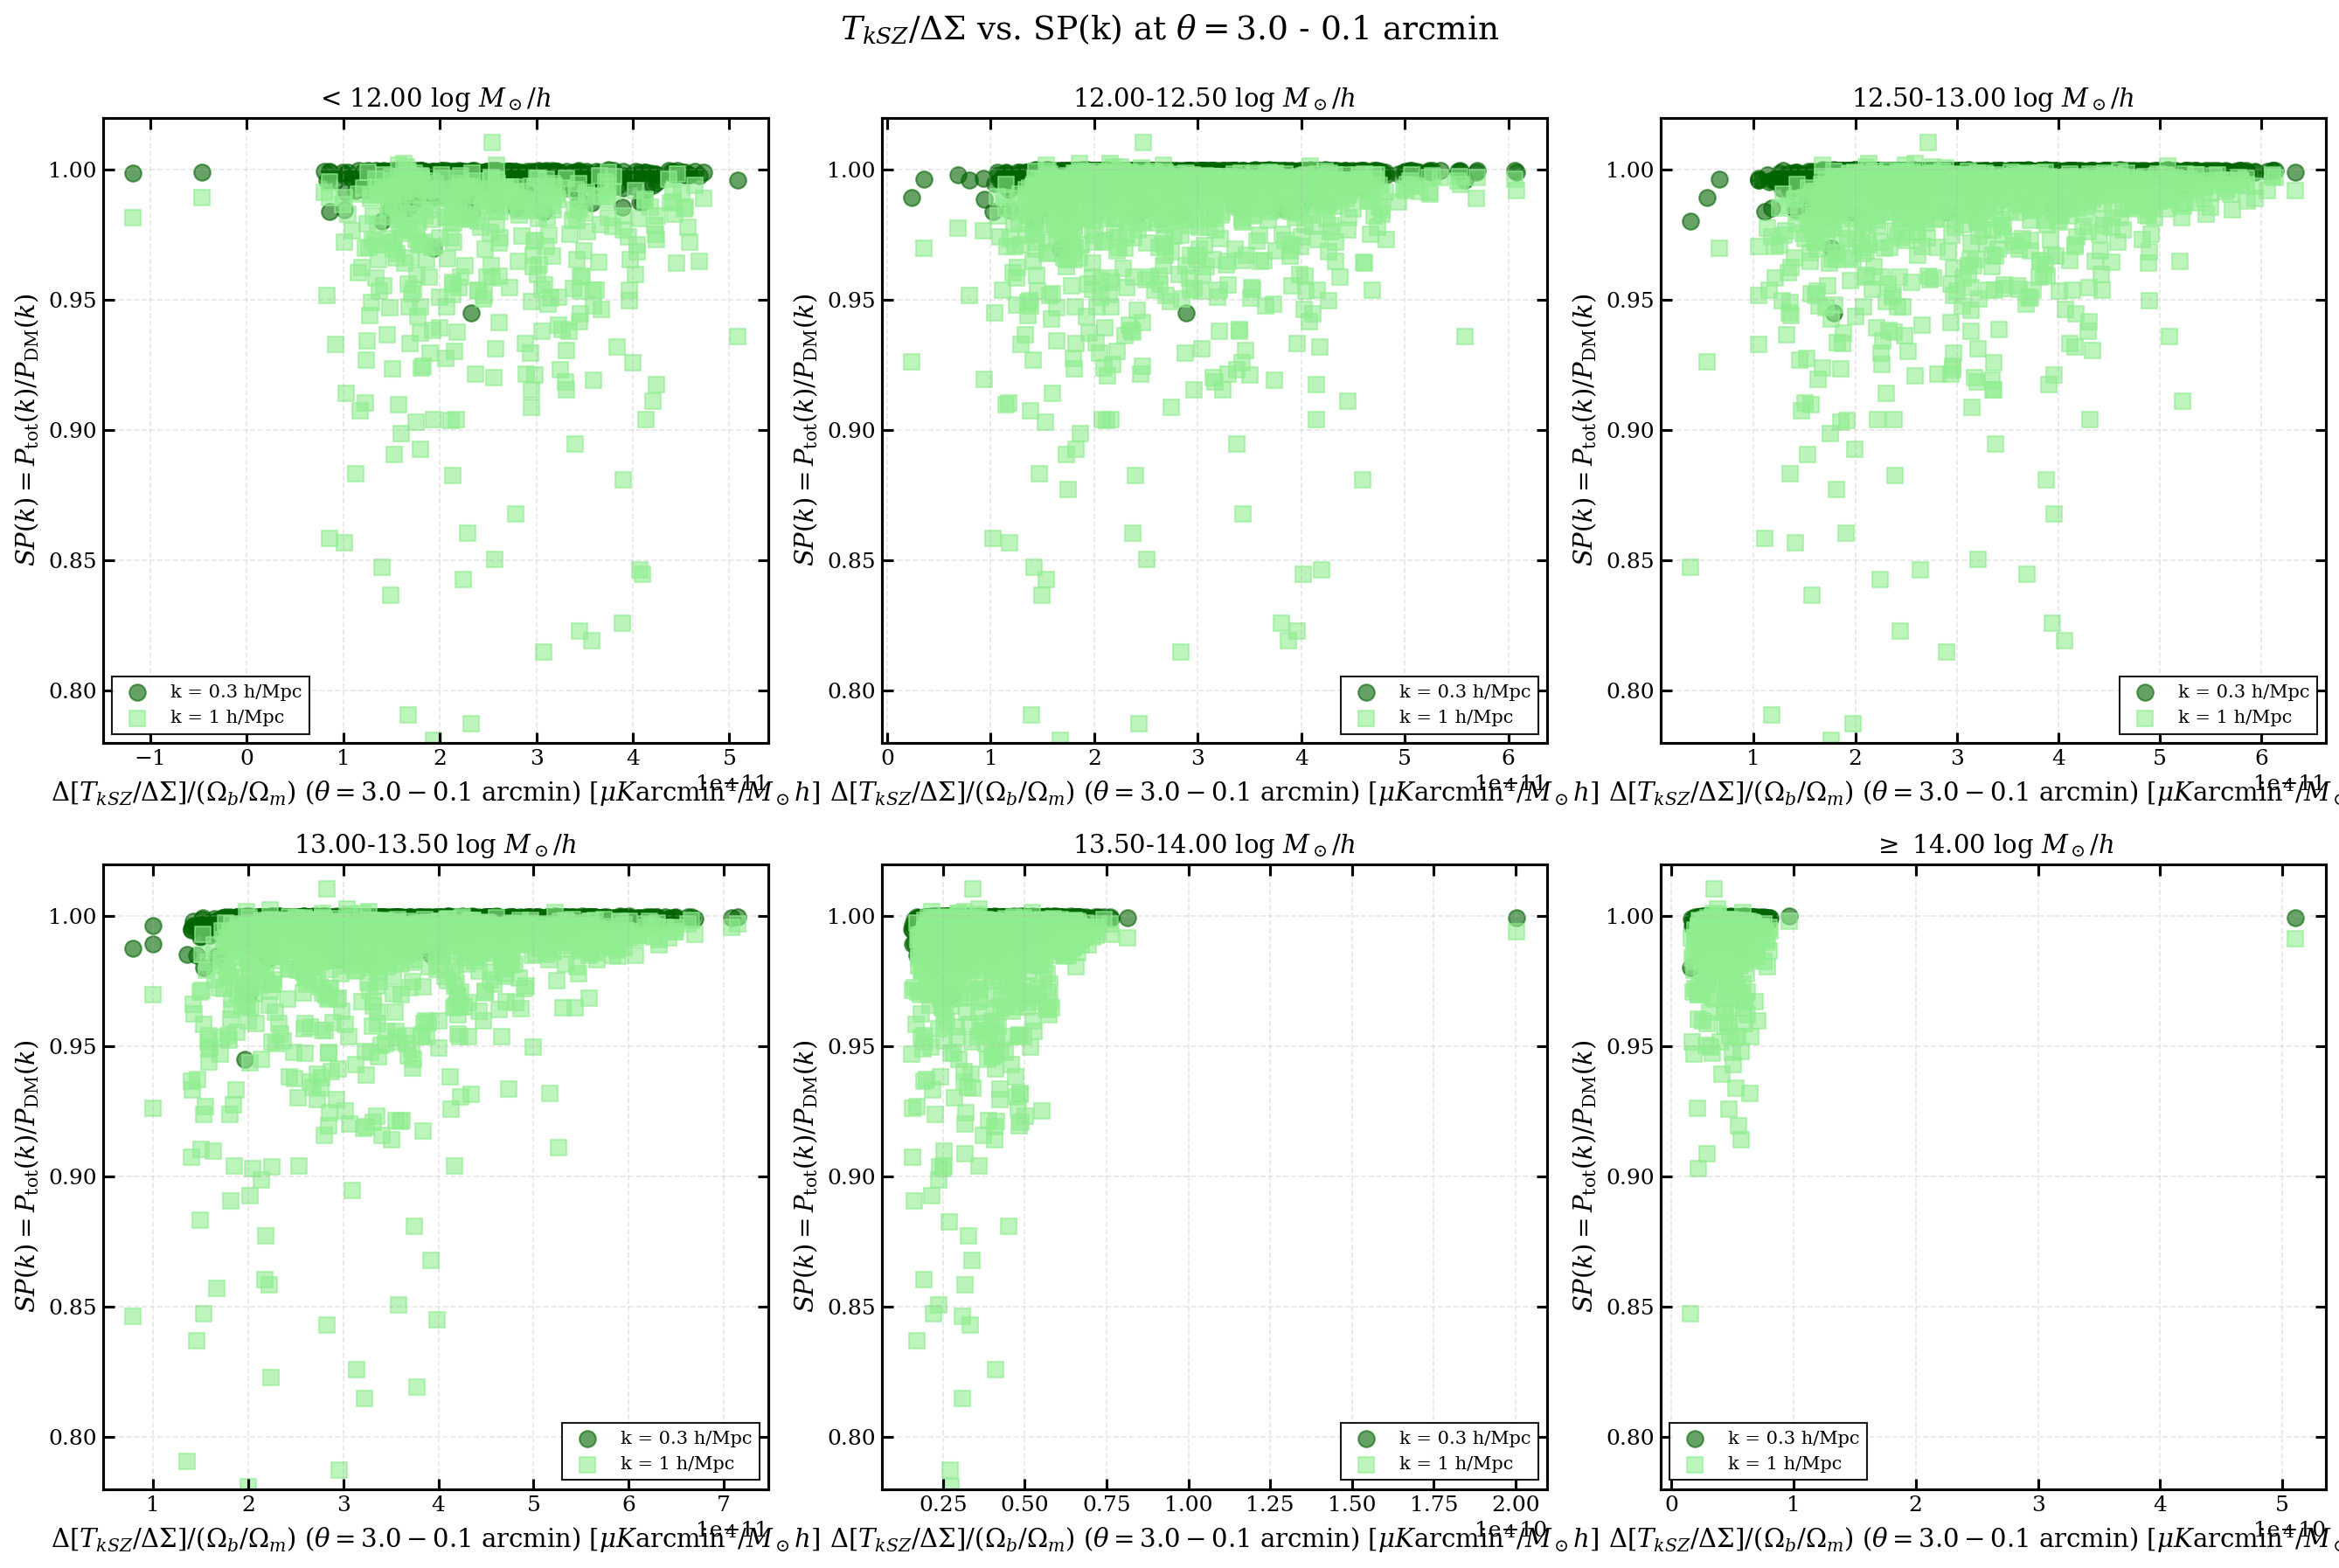

In [86]:
plot_ratio_vs_suppression(k_value1=0.3, k_value2=1, theta_arcmin_value1=0.1, theta_arcmin_value2=3)

In [54]:
r1_mpch_all_sims[0]

array([ 0.05701506,  0.1995527 ,  0.34209034,  0.48462799,  0.62716563,
        0.76970327,  0.91224092,  1.05477856,  1.1973162 ,  1.33985385,
        1.48239149,  1.62492913,  1.76746678,  1.91000442,  2.05254206,
        2.36587616,  2.72704278,  3.14334386,  3.62319606,  4.17630086,
        4.81384076,  5.54870534,  6.39575185,  7.37210559,  8.49750619,
        9.79470662, 11.28993325, 13.01341611, 15.        ])

In [55]:
r1_mpch_all_sims[15]

array([ 0.05737159,  0.20080057,  0.34422956,  0.48765854,  0.63108752,
        0.7745165 ,  0.91794548,  1.06137446,  1.20480345,  1.34823243,
        1.49166141,  1.63509039,  1.77851937,  1.92194836,  2.06537734,
        2.379611  ,  2.74165326,  3.15877789,  3.63936531,  4.19307095,
        4.8310193 ,  5.56602731,  6.412862  ,  7.38853704,  8.51265467,
        9.80779944, 11.29999204, 13.01921198, 15.        ])

In [56]:
r1_arcmin_all_sims[15]

array([ 0.16666667,  0.58333333,  1.        ,  1.41666667,  1.83333333,
        2.25      ,  2.66666667,  3.08333333,  3.5       ,  3.91666667,
        4.33333333,  4.75      ,  5.16666667,  5.58333333,  6.        ,
        6.91286079,  7.96460738,  9.17637035, 10.57249513, 12.18103117,
       14.03429546, 16.1695218 , 18.62960888, 21.46398212, 24.72958674,
       28.49203175, 32.82690819, 37.82130774, 43.57557255])